# control estimation of attraction in the presence of diffusion
Tim Tyree<br>
11.2.2021

In [1]:
import cupy as cp, numpy as np
import time
import matplotlib.pyplot as plt
from lib import *
from scipy.signal import savgol_filter
import dask.bag as db

In [2]:
from lib.lib_care.measure.bootstrap import bin_and_bootstrap_xy_values_parallel

In [3]:
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [4]:
seed=42
# #random number stream A
# rs = RandomState(MT19937(SeedSequence(seed)))
# #random number stream B
# # rs = RandomState(MT19937(SeedSequence(987654321)))
np.random.seed(seed)
# cp.random.seed(seed)

# define module  - TODO: port module to lib

In [15]:
def gener_positions_control(
    num_pairs=1500, #number of independent pairs of particles
    a=5, #cm^2/s known attraction coefficient 
    D=1, #cm^2/s known diffusion coefficient
    Dt=1e-5,
    print_every=100000,
    rend=0.1, #cm
    printing=False,**kwargs
):
    '''
    Example Usage:
    positions_out,mean_array,std_array=gener_positions_control(a=a,D=D,printing=True)
    '''
    #initialize particles locations as being at the same locations
    t=0
    x1=0
    x2=0.5
    y1=0
    y2=0.5
    zero_values=np.zeros(num_pairs)

    x1_values=zero_values.copy()+x1
    x2_values=zero_values.copy()+x2
    y1_values=zero_values.copy()+y1
    y2_values=zero_values.copy()+y2

    stepscale = np.sqrt(2 * D * Dt)
    impulse_prefactor = a * Dt

    tmax=10#0.1#1 #seconds
    num_steps=np.int64(np.around(tmax/Dt))

    position_array=np.zeros(shape=(num_steps,4,num_pairs))+np.nan
    mean_array=np.zeros(shape=(num_steps,3))
    std_array=np.zeros(shape=(num_steps,3))

    #GOAL: add support for still_running

    boo_still_running=zero_values==zero_values
    #TODO: initiallize still_running to True
    #TODO: compute boo where particles become smaller than R_

    #compute the distance between each pair of particles
    dx_values=(x2_values-x1_values)
    dy_values=(y2_values-y1_values)
    Rsq_values=dx_values*dx_values+dy_values*dy_values

    if printing:
        print(f"running simulation for {num_steps} steps...")
    start=time.time()
    for step_num in range(num_steps):
        #compute the attractive step between all pairs
        f_values=impulse_prefactor/Rsq_values
        F1x=f_values*dx_values
        F1y=f_values*dy_values

        #compute the diffusive step between all pairs
        dxW1_values=stepscale*np.random.normal(size=num_pairs)
        dxW2_values=stepscale*np.random.normal(size=num_pairs)
        dyW1_values=stepscale*np.random.normal(size=num_pairs)
        dyW2_values=stepscale*np.random.normal(size=num_pairs)

        #the mean distance between all pairs of particles
        R_values=np.sqrt(Rsq_values)
        mean_R=np.mean(R_values)
        std_R=np.mean(R_values)

        #the mean magnitude of the diffusive step
        diffusive_step_values=0.5*np.sqrt(dxW1_values**2+dyW1_values**2)+0.5*np.sqrt(dxW2_values**2+dyW2_values**2)
        mean_diffusive_step=np.mean(diffusive_step_values)
        std_diffusive_step=np.std(diffusive_step_values)

        #the mean magnitude of the attractive step
        attractive_step_values=np.sqrt(F1x**2+F1y**2)
        mean_attractive_step=np.mean(attractive_step_values)
        std_attractive_step=np.std(attractive_step_values)
        if printing:
            if (step_num+1) % print_every == 0:
                relative_percent=100*mean_diffusive_step/mean_attractive_step
                print(f"simulation {100*(step_num+1)/num_steps:.0f}% completed: R={mean_R:.4f}+/-{1.96*std_R:.4f}, diffusion/attraction is {relative_percent:.2f}%")
                # print(f"the mean range is {mean_R:.4f} cm")
                # print(f"the mean diffusive step was {100*mean_diffusive_step/mean_attractive_step:.2f}% larger than the mean attractive step")

        #compute the net change in position 
        x1step_values=F1x+dxW1_values
        y1step_values=F1y+dyW1_values
        x2step_values=-F1x+dxW2_values
        y2step_values=-F1y+dyW2_values

        #identify any particles that didn't get within the threshold distance
        #compute the distance between each pair of particles
        dx_values=(x2_values-x1_values)
        dy_values=(y2_values-y1_values)
        Rsq_values=dx_values*dx_values+dy_values*dy_values

        #update particle locations if they are still running
        x1_values[boo_still_running]=x1_values[boo_still_running]+x1step_values[boo_still_running]
        y1_values[boo_still_running]=y1_values[boo_still_running]+y1step_values[boo_still_running]
        x2_values[boo_still_running]=x2_values[boo_still_running]+x2step_values[boo_still_running]
        y2_values[boo_still_running]=y2_values[boo_still_running]+y2step_values[boo_still_running]
        #DONE: verified the mean distance between particles got smaller    
        # if (step_count+1) % save_every == 0:
        #save particle locations to a numpy array with the correct number of positions
        # x1,y1,x2,y2
        position_array[step_num,0,boo_still_running]=x1_values[boo_still_running]
        position_array[step_num,1,boo_still_running]=y1_values[boo_still_running]
        position_array[step_num,2,boo_still_running]=x2_values[boo_still_running]
        position_array[step_num,3,boo_still_running]=y2_values[boo_still_running]
        mean_array[step_num,0]=mean_R
        mean_array[step_num,1]=mean_diffusive_step
        mean_array[step_num,2]=mean_attractive_step
        #save results for quick plotting
        std_array[step_num,0]=std_R
        std_array[step_num,1]=std_diffusive_step
        std_array[step_num,2]=std_attractive_step

    #         #identify any particles that didn't get within the threshold distance
    #         #compute the distance between each pair of particles
    #         dx_values=(x2_values-x1_values)
    #         dy_values=(y2_values-y1_values)
    #         Rsq_values=dx_values*dx_values+dy_values*dy_values
        R_values=np.sqrt(Rsq_values)
        boo_still_running=boo_still_running&(R_values>rend)

    if printing:
        print(f"simulation complete!\nTotal run time: {time.time()-start:.4f} seconds")
        print(f"the number of particles that didn't finished is {sum(boo_still_running)} out of {boo_still_running.shape[0]}.")

    #DONE: compute the apparent attraction coefficient without smoothing
    # np.argwhere(np.isnan(position_array[:,0,i])).flatten()
    #identify any pairs that didn't end up closer than rend
    boo_didnt_finish=~np.isnan(position_array[-1,0,:])
    pairs_didnt_finish=np.argwhere(boo_didnt_finish).flatten()
    #     if printing:
    #         print((boo_didnt_finish.shape,pairs_didnt_finish))
    set_pairs_ignore=set(pairs_didnt_finish)

    tmax_recall=0.055 #max time to recall before the value is not nan
    num_rows_recall=np.int64(np.around(tmax_recall/Dt))
    if printing:
        print(num_rows_recall)

    #for each pair, identify the last row where the value is not nan
    row_end_values=zero_values.copy()+np.nan
    for i in range(num_pairs):
        if not set_pairs_ignore.issuperset({i}):
            row_end=np.int64(np.argwhere(np.isnan(position_array[:,0,i]))[0,0])-1
            row_end_values[i]=row_end
    #         #this step can introduce some error
    #         if row_end<num_rows_recall:
    #             #add this i to the ignore list
    #             set_pairs_ignore.add(i)

    #DONE: add pair to set_pairs_ignore if it ends sooner than num_rows_recall

    #for each pair not to be ignored, put the last num_rows_recall before row_end_values into an array
    positions_lst=[]
    for i in range(num_pairs):
        if not set_pairs_ignore.issuperset({i}):
            row_end=np.int64(row_end_values[i])
            if row_end>=num_rows_recall:
                positions=position_array[row_end-num_rows_recall:row_end,:,i]
            else:
                num_rows_rec=row_end
                num_rows_pad=num_rows_recall-row_end
                #pad the start with nans
                nan_pad=np.full([num_rows_pad,4], np.nan)
                positions=position_array[row_end-num_rows_rec:row_end,:,i]
                #pad positions at its front
                positions=np.concatenate((nan_pad,positions))

            positions_lst.append(positions)
    positions_out=np.stack(positions_lst,axis=-1)
    del position_array
    del positions_lst
    return positions_out,mean_array,std_array

Recall that it can be shown that
    $$
    dW(s')dW(s)=s\delta_{ss'};\; \int_0^tWdW(s)=\frac{1}{2}W(t)^2-\frac{1}{2}t^2
    $$

__Lemma__
$$
\int_0^tdW(s)[W(s)]_\alpha=\frac{1}{2}W^2(t)+(\alpha-\frac{1}{2})t
$$

__Result__
The slope of the mean squared range until collision can be used to estimate the attraction coeffiecient in the presence of diffusion.

__Proof__

Let 
$$
dR=-\frac{2a}{R}dt + CdW.
$$
Then, 

$$\begin{eqnarray}
\mathbb{E}[R^2(t)] &=& \mathbb{E}[\int_0^tdR^2(s)] \\
&=& \int_0^t\mathbb{E}[2RdR(s)] \qquad \text{product rule}\\
&=& \int_0^t\mathbb{E}[2R(-\frac{2a}{R}ds + CdW(s))] + R_0^2 \qquad \text{substitution} \\
&=& 2\int_0^t(-2ads)+2C\int_0^t \mathbb{E}[RdW(s)] + R_0^2 \qquad \text{linearity} \\
&=& -4at+2C\int_0^t\mathbb{E}\big[\big(R_0+\int_0^s-\frac{2a}{R}ds' + \int_0^sCdW(s')\big)dW(s)\big] + R_0^2 \qquad \text{substitution} \\
&=& -4at+2C^2\int_0^t \mathbb{E}[\int_0^s dW(s')dW(s)] + R_0^2 \\
&=& -4at+2C^2\mathbb{E}[\int_0^t W(s)dW(s)] + R_0^2 \\
&=& -4at+2C^2\mathbb{E}[\int_0^t dW(s)[W(s)]_\alpha] + R_0^2 \qquad \text{choose discretization } \alpha\in[0,1) \\
&=& -4at+2C^2\mathbb{E}[\frac{1}{2}W^2(t)+(\alpha-\frac{1}{2})t] + R_0^2 \\
&=& -4at+C^2(t+2\alpha t - t) + R_0^2 \\
&=& -4at+2C^2\alpha t + R_0^2 \\
&=& -4(a-\frac{1}{2}\alpha C^2)t + R_0^2 \\
&\equiv& -4\hat{a}t + R_0^2 \\
&\equiv& 4\hat{a}(t_f-t) \\
\end{eqnarray}$$


For $\alpha=0$ (It$\hat{o}$), we have $\hat{a}=a$.

For $\alpha=1/2$ (Stratonivich) and for $C=\sqrt{8D}$, we have 

$$
a=\hat{a}-\frac{1}{2}\alpha C^2 =\hat{a}-2D
$$

Equivalently,

$$
\hat{a}=a+2D
$$

This suggests that (in the Stratovinich picture, we would expect the apparent attraction coefficient $\hat{a}$ estimated by ordinary least squares to be larger than the ground truth attraction coefficient, $a$, by an amount $D$.

In [6]:
22000/5500

4.0

In [7]:
# for p in positions_lst:
#     print(len(p))

In [8]:
# #TODO: solve the array length disagreement in positions_lst
# D

In [16]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float,axis=0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [17]:
def compute_attraction_coefficient_results(positions_out,tavg1,tavg2,Dt,printing=False,**kwargs):
    '''
    Example Usage:
    df=compute_attraction_coefficient_results(positions_out,tavg1,tavg2,Dt)
    '''
    navg1=np.int64(np.around(tavg1/(Dt*10**3)))
    navg2=np.int64(np.around(tavg2/(Dt*10**3)))

    #define time points
    #i=0
    num_timepoints=positions_out.shape[0]
    t_values=np.arange(0,Dt*num_timepoints,Dt)
    #assert t_values.shape==range_values[:,i].shape
    
    #moving avg
    if tavg1>0:
        #compute the moving average of the positional trajectories
        tavg_values=moving_average(t_values,n=navg1)
        positions_out_ma=moving_average(positions_out, n=navg1)
    else:
        tavg_values=t_values
        positions_out_ma=positions_out

    #compute range # x1,y1,x2,y2
    range_values= np.sqrt((positions_out_ma[:,0,:]-positions_out_ma[:,2,:])**2 + (positions_out_ma[:,1,:]-positions_out_ma[:,3,:])**2)


    R_savgol_values=range_values.copy()
    #compute savgol filter
    if navg2>0:
        if navg2<30: navg2=30
        if navg2%2==0:navg2+=1
        #DONE: test whether there is a significant difference between the savgol derivative and the finite difference derivative of the savgol filter
        savgol_kwargs = dict(window_length=navg2,polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
        #compute the savgol_filtered values for R
        for i in range(range_values.shape[1]):
            R_savgol_values[:,i]=savgol_filter(range_values[:,i],**savgol_kwargs)
        SR_values=R_savgol_values**2
    else:
        SR_values=range_values**2

    #DONE: sompute MSR_values from SR_values
    # SR_values

#     if printing:
#         print('nota bene: nan values are being kept in positions_out, so care needs to be taken to compute the particle averaged SR for every time')
#         print(f"HINT: I need to compute the nonnan boolean index for each time slice")
    #np.isnan(SR_values).any(),SR_values.shape
    # assert not np.isnan(positions_out).any()

    # the nonnan boolean index for each time slice
    MSR_values=np.zeros_like(SR_values[:,0])
    num_tbin,num_trials=SR_values.shape
    for j in range (num_tbin):
        boo=~np.isnan(SR_values[j,:])
        MSR_values[j]=np.mean(SR_values[j,boo])

    t_thresh_values=np.arange(0.005,0.04,0.005)

#     start=time.time()
    #generate apparent attraction coefficient data
    a_sr_lst=[]
    Delta_a_sr_lst=[]
    Rsq_sr_lst=[]
    # a_one_over_R_lst=[]
    # Delta_a_one_over_R_lst=[]
    # Rsq_one_over_R_lst=[]
    tdeath_values=np.max(tavg_values)-tavg_values
    for t_thresh in t_thresh_values:
        #squared range method
        boo=tdeath_values<=t_thresh
        boo&=~np.isnan(MSR_values)
        if sum(boo)>2:
            dict_sr=compute_slope.compute_95CI_ols(tdeath_values[boo], MSR_values[boo])
            a_sr=dict_sr['m']/4
            Delta_a_sr=dict_sr['Delta_m']/4
            Rsquared=dict_sr['Rsquared']
        else:
            a_sr=np.nan
            Delta_a_sr=np.nan
            Rsquared=np.nan
            
    #     #inverse range method
    #     boo=one_over_R_values<1/R_thresh
    #     dict_one_over_R=compute_slope.compute_95CI_ols(one_over_R_values[boo], dRdt_values[boo])
    #     a_one_over_R=-1*dict_one_over_R['m']/2
    #     Delta_a_one_over_R=dict_one_over_R['Delta_m']/2

        #record results
        a_sr_lst.append(a_sr)
        Delta_a_sr_lst.append(Delta_a_sr)
        Rsq_sr_lst.append(Rsquared)
    #     a_one_over_R_lst.append(a_one_over_R)
    #     Delta_a_one_over_R_lst.append(Delta_a_one_over_R)
    #     Rsq_one_over_R_lst.append(dict_one_over_R['Rsquared'])
#     if printing:
#         print(f"runtime computing attraction coefficients: {time.time()-start:.4f}")

    df=pd.DataFrame({
        'tavg1':tavg1,
        'tavg2':tavg2,
        'tmax':t_thresh_values,
        'a':a_sr_lst,
        'Delta_a':Delta_a_sr_lst,
        'Rsq_a':Rsq_sr_lst
    })
    return df

In [18]:
#     num_pairs=1500, #number of independent pairs of particles
#     a=5, #cm^2/s known attraction coefficient 
#     D=1, #cm^2/s known diffusion coefficient
#     Dt=1e-5,
1
#     print_every=100000,
#     rend=0.1, #cm
#     printing=False,**kwargs

1

In [19]:
def save_control_results_for_setting(a,
                                     D,
                                     Dt,
                                     tavg_step=0.1,
                                     tavg1_max=20,
                                     tavg2_max=20,
                                     printing=False,
                                    save_folder=None,**kwargs):
    if not save_folder:
        nb_dir=os.getcwd()
        save_folder = f"{nb_dir}/data/control_data/arrays"
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
    save_dir = os.path.join(save_folder, f"control_a_{a}_D_{D}.npz")

    use_cache = False
    caching = False

    if use_cache:
        arr = np.load(save_dir)
        positions_out = arr['arr_0']
    else:
        positions_out, mean_array, std_array = gener_positions_control(
            a=a, D=D, printing=printing,**kwargs)

    if caching:
        #save array of positions to .npz
        np.savez_compressed(save_dir, positions_out)
        assert (os.path.exists(save_dir))

        if printing:
            print('saving array in:')
            print(save_dir)

    #save the raw mean squared range versus time until death to npz
    range_values= np.sqrt((positions_out[:,0,:]-positions_out[:,2,:])**2 + (positions_out[:,1,:]-positions_out[:,3,:])**2)
    SR_values=range_values**2
    MSR_values=np.zeros_like(SR_values[:,0])
    num_tbin,num_trials=SR_values.shape
    for j in range (num_tbin):
        boo=~np.isnan(SR_values[j,:])
        MSR_values[j]=np.mean(SR_values[j,boo])
    num_timepoints=positions_out.shape[0]
    t_values=np.arange(0,Dt*num_timepoints,Dt)
    tdeath_values=np.max(t_values)-t_values
    npz_dir = os.path.join(save_folder, f"control_a_{a}_D_{D}.npz")
    np.savez_compressed(npz_dir,MSR=MSR_values,tdeath=tdeath_values)
#     return npz_dir
    start=time.time()
    df_lst = []
    for tavg1 in np.arange(0, tavg1_max, tavg_step):
        for tavg2 in np.arange(0, tavg2_max, tavg_step):
            df = compute_attraction_coefficient_results(
                positions_out=positions_out, tavg1=tavg1, tavg2=tavg2, Dt=Dt,printing=printing)
            df_lst.append(df)
    df_out = pd.concat(df_lst)
    del df_lst
    if printing:
        print(f"runtime computing attraction coefficients: {time.time()-start:.4f}")

    csv_dir = os.path.join(save_folder, f"control_a_{a}_D_{D}.csv")
    df_out.to_csv(csv_dir, index=False)
    return csv_dir

In [20]:
#TODO: port to lib:
#this block tares ballistically annihilating particles
#TODO: accelerate tshift_tare_routine
#NOTA BENE: the same memory, df_Ri, is being accessed by every worker simultaneously...
#TODO: compare runtimes with cudf.DataFrame(df_Ri)
def tshift_tare_routine(df_R,navg2,max_num_groups=9e9,npartitions=None,R_col='R_nosavgol',printing=True,**kwargs):
    '''
    Nota Bene: the same memory, df_Ri, is being accessed by every worker simultaneously...

    Example Usage:
    retval=tshift_tare_routine(df_R,navg2,max_num_groups=9e9,plotting=False,npartitions=None,R_col='R_nosavgol')
    tshift_align_lst,speed_align_lst,group_name_lst,SR_speed_align_lst,Delta_SR_speed_align_lst=retval
    '''
    navg2=navg2 if navg2%2==1 else navg2+1
    #TODO: accelerate tshift_tare_routine
    #compute time shifts for the first x groups
    #include memory preallocation 
    df_R['tdeath_align']=df_R['tdeath'].copy()
    #sort by time
    df_R.sort_values(by='tdeath',ascending=True,inplace=True)
    #group dataframe by annihilation event
    # groups=df_R.sort_values('tdeath',ascending=True).groupby(['event_id_int','pid_self','pid_other'])
    groups=df_R.groupby(['event_id_int','pid_self','pid_other'])
    df_Ri=df_R.set_index(['event_id_int','pid_self','pid_other'])
    # groups=df_fk.sort_values('tdeath',ascending=True).groupby(['event_id_int','pid_self','pid_other'])
    tshift_align_lst=[]
    speed_align_lst=[]
    group_name_lst=[]
    SR_speed_align_lst=[]
    Delta_SR_speed_align_lst=[]
    count=0
    task_lst=[]
    for group_name,g in groups:
        count+=1
        if max_num_groups>=count:
            data=group_name,g
            #TODO: generate task_lst
            task_lst.append(data)
    
    #DONE: accelerate tshift_tare_routine here
    def eval_routine(data):
        mode='diff'#'ols'
        group_name,g=data
        #to compute tshift_align,
        savgol_kwargs=dict(
                window_length=navg2,
                polyorder=3,
                deriv=1,
                delta=1.0,
                axis=-1,
                mode='interp')
        savgol0_kwargs=dict(
                window_length=navg2,
                polyorder=3,
                deriv=0,
                delta=1.0,
                axis=-1,
                mode='interp')

        #extract the R_values and tdeath_values
        tdeath_values=g['tdeath'].values
        SR_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)**2
        #perform ols least squares on the final 8 values
        if mode=='ols':  
            y=SR_values[:8]
            x=tdeath_values[:8]
        else:# mode=='diff':
            y=SR_values[:3]
            x=tdeath_values[:3]
            
        dict_ols=compute_95CI_ols(x,y)
        m=dict_ols['m']
        SR_speed_align=m
        Delta_SR_speed_align=dict_ols['Delta_m']
        #compute the time shift
        tf=x[0]
        tshift_align=float(tf+dict_ols['b']/m)
#         else:
#             SR_speed_align=-9999
#             Delta_SR_speed_align=-9999
#             tshift_align=-9999
#             #raise(r'Exception: mode={mode} not implemented!')
        #compute tdeath_align from tdeath and the moving average of speed
        #tshift trajectories by that value
        return tshift_align,group_name,SR_speed_align,Delta_SR_speed_align
    def routine(data):
        try:
            return eval_routine(data)
        except Exception as e:
            return f"Warning: {e} for data={data}..."
    
    #TODO: dask bag accelerate tshift_tare_routine
    if npartitions is None:
        npartitions=os.cpu_count()
    #all CPU version
    b = db.from_sequence(task_lst, npartitions=npartitions).map(routine)
    #TODO: evaluate task_lst
    start = time.time()
    retval = list(b)
    if printing:
        print(f"run time aligning trajectories was {time.time()-start:.2f} seconds.")
    return retval
#     tshift_align_lst,group_name_lst,SR_speed_align_lst,Delta_SR_speed_align_lst=retval
#     #TODO(maybe needed?): transpose output retval to lists
#     return tshift_align_lst,group_name_lst,SR_speed_align_lst,Delta_SR_speed_align_lst

In [21]:
# np.savez_compressed

# single simulation of diffusion in an unbounded domain

- TODO: grid search over D from 0.1 to 2 in steps of 0.1
- (GPU accelerate in cupy)
- TODO: rewrite it from scratch, developing in vectorized pairs of particles
- start 2 particles 1/np.sqrt(2) away from one another

__Schema__
1. t,x1,x2,y1,y2,pair_num

In [13]:
# rend=0.1#0.0001 #cm
# printing=False#,**kwargs
# # printing=True

In [150]:
# num_pairs=1500#5000 #number of independent pairs of particles
# a=5 #cm^2/s known attraction coefficient 
# D=1 #cm^2/s known diffusion coefficient
# Dt=1e-5
# a=9.5;D=0.7;num_pairs=5,;tavg_step=0.5,;tavg1_max=1,;tavg2_max=1
# 1.604153

# #FK (a_hat short timescale, D_hat long timescale)
# a=7.3923;D=0.365238;num_pairs=25;tavg_step=5;tavg1_max=15;tavg2_max=15
# npz_dir_FK='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_7.3923_D_0.365238.npz'#csv'

# # #FK (a_hat long timescale, D_hat long timescale)
# a=1.604153;D=0.365238;num_pairs=25;tavg_step=5;tavg1_max=15;tavg2_max=15
# npz_dir_FK='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_1.604153_D_0.365238.csv'

# #LR (a_hat short timescale, D_hat long timescale)
# a=8.595;D=0.586055;num_pairs=25;tavg_step=5;tavg1_max=15;tavg2_max=15
# npz_dir_LR='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_8.595_D_0.586055.npz'#.csv'

In [151]:
# save_folder='/home/AD/tttyree/bgmc_data'#None
save_folder=None
#~2min runtime for ~25min
#~15 min runtime per trial
testing=True
if testing:
    fn_out=save_control_results_for_setting(a=a,D=D,Dt=1e-5,
                                    num_pairs=num_pairs,
                                    tavg_step=tavg_step,
                                    tavg1_max=tavg1_max,
                                    tavg2_max=tavg2_max,printing=True,save_folder=save_folder)
    df=pd.read_csv(fn_out)
    print(df.head(10))

running simulation for 1000000 steps...
simulation 10% completed: R=0.0991+/-0.1943, diffusion/attraction is 2230.86%
simulation 20% completed: R=0.0991+/-0.1943, diffusion/attraction is 2436.22%
simulation 30% completed: R=0.0991+/-0.1943, diffusion/attraction is 1965.23%
simulation 40% completed: R=0.0991+/-0.1943, diffusion/attraction is 2239.55%
simulation 50% completed: R=0.0991+/-0.1943, diffusion/attraction is 1987.70%
simulation 60% completed: R=0.0991+/-0.1943, diffusion/attraction is 2197.52%
simulation 70% completed: R=0.0991+/-0.1943, diffusion/attraction is 1656.26%
simulation 80% completed: R=0.0991+/-0.1943, diffusion/attraction is 2250.62%
simulation 90% completed: R=0.0991+/-0.1943, diffusion/attraction is 2072.22%
simulation 100% completed: R=0.0991+/-0.1943, diffusion/attraction is 2077.85%
simulation complete!
Total run time: 111.3139 seconds
the number of particles that didn't finished is 0 out of 25.
5500
runtime computing attraction coefficients: 1.3291
   tavg1 

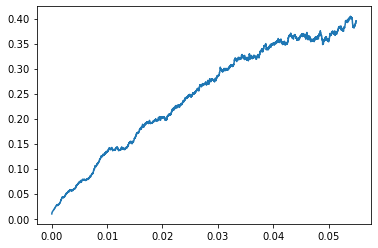

'/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_1.604153_D_0.365238.csv'

In [155]:
#verify the raw trace was saved
arr=np.load(fn_out.replace('.csv','.npz'))
MSR_values=arr['MSR']
tdeath_values=arr['tdeath']
plt.plot(tdeath_values,MSR_values)
plt.show()
fn_out

## visualize values predicted by the particle model for the full model

In [202]:
# # #FK (a_hat short timescale, D_hat long timescale)
# a_FK=7.3923;D_FK=0.365238#;num_pairs=25;tavg_step=5;tavg1_max=15;tavg2_max=15
# npz_dir_FK='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_7.3923_D_0.365238.npz'#csv'

# #FK (a_hat long timescale, D_hat long timescale)
a=1.604153;D=0.365238;num_pairs=25;tavg_step=5;tavg1_max=15;tavg2_max=15
npz_dir_FK='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_1.604153_D_0.365238.npz'

#LR (a_hat short timescale, D_hat long timescale)
a_LR=8.595;D_LR=0.586055#;num_pairs=25;tavg_step=5;tavg1_max=15;tavg2_max=15
npz_dir_LR='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_8.595_D_0.586055.npz'#.csv'

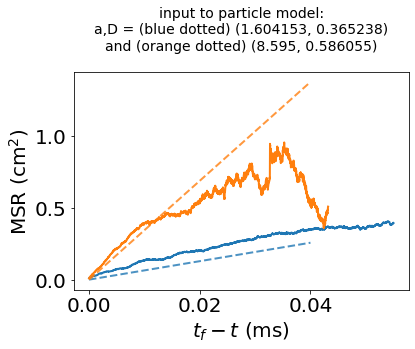

In [203]:
xv=np.linspace(0,.04,100)
#plot data for FK
arr=np.load(npz_dir_FK)
plt.plot(arr['tdeath'],arr['MSR'],lw=2,alpha=1,c='C0')
plt.plot(xv,4*a_FK*xv,'--',lw=2,alpha=0.8,c='C0')

#plot data for LR
arr=np.load(npz_dir_LR)
plt.plot(arr['tdeath'],arr['MSR'],lw=2,alpha=1,c='C1')
plt.plot(xv,4*a_LR*xv,'--',lw=2,alpha=0.8,c='C1')

# plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# plt.xlim([0,180])
# plt.ylim([0,3.1])
plt.title(f"input to particle model:\na,D = (blue dotted) {a_FK,D_FK}\nand (orange dotted) {a_LR,D_LR}\n",fontsize=14)
plt.show()

In [204]:
a_hat_LR

# # tmax=8#ms
# tmax=1e3#ms
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_SR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s")
print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

a_SR = 3.535902+/-0.312245 cm^2/s
tavg2=14 ms, num_samples=19087


a_SR = 2.531453+/-0.027286 cm^2/s, tmax=8
a_SR = 9.984632+/-0.036228 cm^2/s, tmax=8


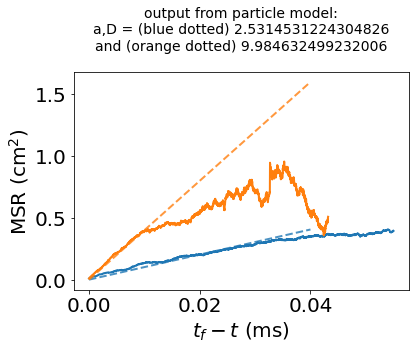

In [205]:
tmax=8#ms
xv=np.linspace(0,.04,100)
#plot data for FK
arr=np.load(npz_dir_FK)
x_values=arr['tdeath']
y_values=arr['MSR']
boo=x_values<tmax*1e-3 #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4#*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4#*1e3
print(f"a_SR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_FK=a_SR

plt.plot(x_values,y_values,lw=2,alpha=1,c='C0')
plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')

# tmax=300#ms
#plot data for LR
arr=np.load(npz_dir_LR)
x_values=arr['tdeath']
y_values=arr['MSR']

boo=x_values<tmax*1e-3 #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4#*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4#*1e3
print(f"a_SR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_LR=a_SR

plt.plot(x_values,y_values,lw=2,alpha=1,c='C1')
plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
# plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# plt.xlim([0,180])
# plt.ylim([0,3.1])
plt.title(f"output from particle model:\na,D = (blue dotted) {a_hat_FK}\nand (orange dotted) {a_hat_LR}\n",fontsize=14)
plt.show()

# Two particle simulation - grid search over multiple a,D values

In [19]:
# num_pairs=1500 #number of independent pairs of particles
# a=5 #cm^2/s known attraction coefficient 
# D=0. #cm^2/s known diffusion coefficient
# Dt=1e-5
# print_every=100000

In [26]:
# D_lst=[0,0.5,1]
# ahat_lst=[5,6,7.16]
# plt.plot(D_lst,ahat_lst)

In [21]:
# save_folder=None#'/home/AD/tttyree/bgmc_data'
# testing=True
# if testing:
#     fn_out=save_control_results_for_setting(a,D,
#                                     tavg_step=0.1,
#                                     tavg1_max=1,
#                                     tavg2_max=1,printing=True,save_folder=save_folder)
#     df=pd.read_csv(fn_out)
#     print(df.head())

In [22]:
D_lst=list(np.arange(0,3.1,0.2))
D_lst.append(0.7)
# D_lst=[0,0.3,0.7]
task_lst=[]
for a in [1.6,9.5]:
    for D in D_lst:#[4:]:
        task_lst.append((a,np.around(D,1)))
len(task_lst),len(task_lst)*15/60#hours if one worker is used... <2 hour if 4 workers are used
# task_lst

(34, 8.5)

In [23]:
np.random.seed(seed)
cp.random.seed(seed)

In [24]:
def routine(data):
    a,D=data
    return save_control_results_for_setting(a,D,Dt=1e-5,
                                    num_pairs=1500,
                                    tavg_step=2.,
                                    tavg1_max=20,
                                    tavg2_max=20,
                                    printing=False,
                                    save_folder='/home/AD/tttyree/bgmc_data')

In [25]:
len(task_lst)/4

8.5

In [26]:
start = time.time()
retval_lst=[]
for task in task_lst:
    retval_lst.append(routine(task))
print(f"the run time for {len(retval_lst)} simulations was {(time.time()-start)/60:.2f} minutes.")

/home/AD/tttyree/anaconda3/envs/pyenv_tt/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/AD/tttyree/anaconda3/envs/pyenv_tt/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


the run time for 34 simulations was 467.86 minutes.


In [27]:
# #apparent runtime=40min
# print(f"note: approximately 45 GB of RAM is needed per worker")
# npartitions=6#1#8
# print(f"running simulation on {npartitions} workers...")
# bag = db.from_sequence(task_lst, npartitions=npartitions).map(routine)
# start = time.time()
# retval_lst = list(bag)
# print(f"the run time for {len(retval_lst)} simulations was {(time.time()-start)/60:.2f} minutes.")
# # return retval_lst
# print(len(retval_lst))

# visualization

In [28]:
positions_out.shape

(5500, 4, 100)

In [29]:
a=5
D=1
positions_out, mean_array, std_array = gener_positions_control(
            a=a, D=D, printing=True,num_pairs=1000)

running simulation for 1000000 steps...
simulation 10% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 20% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 30% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 40% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 50% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 60% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 70% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 80% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 90% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation 100% completed: R=0.0989+/-0.1939, diffusion/attraction is 0.00%
simulation complete!
Total run time: 138.4179 seconds
the number of particles that didn't finished is 0 out of 100.
5500


In [30]:
tavg1=0
tavg2=0
printing=True
np.sqrt(2.6/0.6)
np.sqrt(5)

2.23606797749979

In [31]:
D

0

In [32]:
df = compute_attraction_coefficient_results(
    positions_out=positions_out, tavg1=0, tavg2=0, Dt=1e-5,printing=printing)
df.head()

,tavg1,tavg2,tmax,a,Delta_a,Rsq_a
0,0,0,0.005,7.139568,0.020423,0.998938
1,0,0,0.010,6.840775,0.011598,0.999254
2,0,0,0.015,6.067483,0.030449,0.990269
3,0,0,0.020,5.228016,0.037813,0.973513
4,0,0,0.025,4.576281,0.035718,0.961882


In [33]:
np.sqrt(5)

2.23606797749979

In [34]:
navg1=np.int(np.around(tavg1/(Dt*10**3)))
navg2=np.int(np.around(tavg2/(Dt*10**3)))

#define time points
#i=0
num_timepoints=positions_out.shape[0]
t_values=np.arange(0,Dt*num_timepoints,Dt)
#assert t_values.shape==range_values[:,i].shape

#moving avg
if tavg1>0:
    #compute the moving average of the positional trajectories
    tavg_values=moving_average(t_values,n=navg1)
    positions_out_ma=moving_average(positions_out, n=navg1)
else:
    tavg_values=t_values
    positions_out_ma=positions_out

#compute range # x1,y1,x2,y2
range_values= np.sqrt((positions_out_ma[:,0,:]-positions_out_ma[:,2,:])**2 + (positions_out_ma[:,1,:]-positions_out_ma[:,3,:])**2)



#compute savgol filter
if navg2>0:
    if navg2<30: navg2=30
    if navg2%2==0:navg2+=1
    #DONE: test whether there is a significant difference between the savgol derivative and the finite difference derivative of the savgol filter
    savgol_kwargs = dict(window_length=navg2,polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
    #compute the savgol_filtered values for R
    R_savgol_values=savgol_filter(range_values,**savgol_kwargs)
    SR_values=R_savgol_values**2
else:
    SR_values=range_values**2

#DONE: sompute MSR_values from SR_values
# SR_values

#     if printing:
#         print('nota bene: nan values are being kept in positions_out, so care needs to be taken to compute the particle averaged SR for every time')
#         print(f"HINT: I need to compute the nonnan boolean index for each time slice")
np.isnan(SR_values).any(),SR_values.shape
# assert not np.isnan(positions_out).any()

# the nonnan boolean index for each time slice
MSR_values=np.zeros_like(SR_values[:,0])
num_tbin,num_trials=SR_values.shape
for j in range (num_tbin):
    boo=~np.isnan(SR_values[j,:])
    MSR_values[j]=np.mean(SR_values[j,boo])

t_thresh_values=np.arange(0.005,0.04,0.005)

start=time.time()
#generate apparent attraction coefficient data
a_sr_lst=[]
Delta_a_sr_lst=[]
Rsq_sr_lst=[]
# a_one_over_R_lst=[]
# Delta_a_one_over_R_lst=[]
# Rsq_one_over_R_lst=[]
tdeath_values=np.max(tavg_values)-tavg_values
for t_thresh in t_thresh_values:
    #squared range method
    boo=tdeath_values<=t_thresh
    boo&=~np.isnan(MSR_values)
    if sum(boo)>2:
        dict_sr=compute_slope.compute_95CI_ols(tdeath_values[boo], MSR_values[boo])
        a_sr=dict_sr['m']/4
        Delta_a_sr=dict_sr['Delta_m']/4
        Rsquared=dict_sr['Rsquared']
    else:
        a_sr=np.nan
        Delta_a_sr=np.nan
        Rsquared=np.nan

#     #inverse range method
#     boo=one_over_R_values<1/R_thresh
#     dict_one_over_R=compute_slope.compute_95CI_ols(one_over_R_values[boo], dRdt_values[boo])
#     a_one_over_R=-1*dict_one_over_R['m']/2
#     Delta_a_one_over_R=dict_one_over_R['Delta_m']/2

    #record results
    a_sr_lst.append(a_sr)
    Delta_a_sr_lst.append(Delta_a_sr)
    Rsq_sr_lst.append(Rsquared)
#     a_one_over_R_lst.append(a_one_over_R)
#     Delta_a_one_over_R_lst.append(Delta_a_one_over_R)
#     Rsq_one_over_R_lst.append(dict_one_over_R['Rsquared'])
if printing:
    print(f"runtime computing attraction coefficients: {time.time()-start:.4f}")

df=pd.DataFrame({
    'tavg1':tavg1,
    'tavg2':tavg2,
    'tmax':t_thresh_values,
    'a':a_sr_lst,
    'Delta_a':Delta_a_sr_lst,
    'Rsq_a':Rsq_sr_lst
})
df

runtime computing attraction coefficients: 0.0749


,tavg1,tavg2,tmax,a,Delta_a,Rsq_a
0,0,0,0.005,7.139568,0.020423,0.998938
1,0,0,0.010,6.840775,0.011598,0.999254
2,0,0,0.015,6.067483,0.030449,0.990269
3,0,0,0.020,5.228016,0.037813,0.973513
4,0,0,0.025,4.576281,0.035718,0.961882
5,0,0,0.030,4.184043,0.029931,0.961586
6,0,0,0.035,3.819793,0.027175,0.955944
7,0,0,0.040,3.501530,0.025158,0.949003


In [140]:
navg1=np.int(np.around(tavg1/(Dt*10**3)))
navg2=np.int(np.around(tavg2/(Dt*10**3)))

#define time points
#i=0
num_timepoints=positions_out.shape[0]
t_values=np.arange(0,Dt*num_timepoints,Dt)
#assert t_values.shape==range_values[:,i].shape

#moving avg
if tavg1>0:
    #compute the moving average of the positional trajectories
    tavg_values=moving_average(t_values,n=navg1)
    positions_out_ma=moving_average(positions_out, n=navg1)
else:
    tavg_values=t_values
    positions_out_ma=positions_out

#compute range # x1,y1,x2,y2
range_values= np.sqrt((positions_out_ma[:,0,:]-positions_out_ma[:,2,:])**2 + (positions_out_ma[:,1,:]-positions_out_ma[:,3,:])**2)



#compute savgol filter
if navg2>0:
    if navg2<30: navg2=30
    if navg2%2==0:navg2+=1
    #DONE: test whether there is a significant difference between the savgol derivative and the finite difference derivative of the savgol filter
    savgol_kwargs = dict(window_length=navg2,polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
    #compute the savgol_filtered values for R
    R_savgol_values=savgol_filter(range_values,**savgol_kwargs)
    SR_values=R_savgol_values**2
else:
    SR_values=range_values**2

#DONE: sompute MSR_values from SR_values
# SR_values

#     if printing:
#         print('nota bene: nan values are being kept in positions_out, so care needs to be taken to compute the particle averaged SR for every time')
#         print(f"HINT: I need to compute the nonnan boolean index for each time slice")
np.isnan(SR_values).any(),SR_values.shape
# assert not np.isnan(positions_out).any()

# the nonnan boolean index for each time slice
MSR_values=np.zeros_like(SR_values[:,0])
num_tbin,num_trials=SR_values.shape
for j in range (num_tbin):
    boo=~np.isnan(SR_values[j,:])
    MSR_values[j]=np.mean(SR_values[j,boo])

t_thresh_values=np.arange(0.005,0.04,0.005)


In [141]:
start=time.time()
#generate apparent attraction coefficient data
a_sr_lst=[]
Delta_a_sr_lst=[]
Rsq_sr_lst=[]
# a_one_over_R_lst=[]
# Delta_a_one_over_R_lst=[]
# Rsq_one_over_R_lst=[]
tdeath_values=np.max(tavg_values)-tavg_values
for t_thresh in t_thresh_values:
    #squared range method
    boo=tdeath_values<=t_thresh
    boo&=~np.isnan(MSR_values)
    if sum(boo)>2:
        dict_sr=compute_slope.compute_95CI_ols(tdeath_values[boo], MSR_values[boo])
        a_sr=dict_sr['m']/4
        Delta_a_sr=dict_sr['Delta_m']/4
        Rsquared=dict_sr['Rsquared']
    else:
        a_sr=np.nan
        Delta_a_sr=np.nan
        Rsquared=np.nan

#     #inverse range method
#     boo=one_over_R_values<1/R_thresh
#     dict_one_over_R=compute_slope.compute_95CI_ols(one_over_R_values[boo], dRdt_values[boo])
#     a_one_over_R=-1*dict_one_over_R['m']/2
#     Delta_a_one_over_R=dict_one_over_R['Delta_m']/2

    #record results
    a_sr_lst.append(a_sr)
    Delta_a_sr_lst.append(Delta_a_sr)
    Rsq_sr_lst.append(Rsquared)
#     a_one_over_R_lst.append(a_one_over_R)
#     Delta_a_one_over_R_lst.append(Delta_a_one_over_R)
#     Rsq_one_over_R_lst.append(dict_one_over_R['Rsquared'])
if printing:
    print(f"runtime computing attraction coefficients: {time.time()-start:.4f}")

df=pd.DataFrame({
    'tavg1':tavg1,
    'tavg2':tavg2,
    'tmax':t_thresh_values,
    'a':a_sr_lst,
    'Delta_a':Delta_a_sr_lst,
    'Rsq_a':Rsq_sr_lst
})
df

runtime computing attraction coefficients: 0.0765


,tavg1,tavg2,tmax,a,Delta_a,Rsq_a
0,0,0,0.005,7.139568,0.020423,0.998938
1,0,0,0.010,6.840775,0.011598,0.999254
2,0,0,0.015,6.067483,0.030449,0.990269
3,0,0,0.020,5.228016,0.037813,0.973513
4,0,0,0.025,4.576281,0.035718,0.961882
5,0,0,0.030,4.184043,0.029931,0.961586
6,0,0,0.035,3.819793,0.027175,0.955944
7,0,0,0.040,3.501530,0.025158,0.949003


In [142]:
# the nonnan boolean index for each time slice
MSR_values=np.zeros_like(SR_values[:,0])
num_tbin,num_trials=SR_values.shape
for j in range (num_tbin):
    boo=~np.isnan(SR_values[j,:])
    MSR_values[j]=np.mean(SR_values[j,boo])

t_thresh_values=np.arange(0.005,0.04,0.005)


In [143]:
# start=time.time()
#generate apparent attraction coefficient data
a_sr_lst=[]
Delta_a_sr_lst=[]
Rsq_sr_lst=[]
# a_one_over_R_lst=[]
# Delta_a_one_over_R_lst=[]
# Rsq_one_over_R_lst=[]
tdeath_values=np.max(tavg_values)-tavg_values
for t_thresh in t_thresh_values:
    #squared range method
    boo=tdeath_values<=t_thresh
    boo&=~np.isnan(MSR_values)
    dict_sr=compute_slope.compute_95CI_ols(tdeath_values[boo], MSR_values[boo])
    a_sr=dict_sr['m']/4
    Delta_a_sr=dict_sr['Delta_m']/4
    
a_sr

3.501529675546694

In [144]:
SR_values

array([[       nan,        nan, 2.07751217, ...,        nan,        nan,
               nan],
       [       nan,        nan, 2.07320697, ...,        nan,        nan,
               nan],
       [       nan,        nan, 2.07337873, ...,        nan,        nan,
               nan],
       ...,
       [0.01293852, 0.01016335, 0.01189654, ..., 0.01128866, 0.01256878,
        0.01029097],
       [0.01176645, 0.01176738, 0.01093364, ..., 0.01016212, 0.01043423,
        0.01067259],
       [0.00976229, 0.00752802, 0.00952387, ..., 0.00956764, 0.00892987,
        0.00949838]])

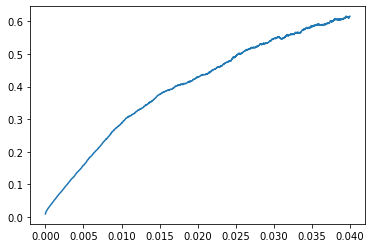

In [145]:
#squared range method
boo=tdeath_values<=t_thresh
boo&=~np.isnan(MSR_values)
plt.plot(tdeath_values[boo], MSR_values[boo])

In [146]:
lst=[]
for j in range(num_tbin):
    boo=~np.isnan(SR_values[j,:])
    lst.append(np.mean(SR_values[j,boo]))
MSR_values=np.array(list(lst))
MSR_values.shape

(5500,)

In [147]:
j=5
boo=~np.isnan(SR_values[j,:])
SR_values[j,:]
np.isnan(SR_values[j,~boo]).any()
np.isnan(SR_values[j]).any()

True

True

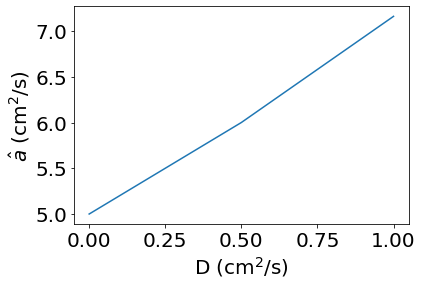

In [132]:
D_lst=[0,0.5,1]
ahat_lst=[5,6,7.16]
plt.plot(D_lst,ahat_lst)
format_plot(ax=plt.gca(),xlabel=r'D (cm$^2$/s)',ylabel=r'$\hat{a}$ (cm$^2$/s)')

In [ ]:
#TODO: measure slope of ^this

In [ ]:
#TODO: figure out why I keep getting stalling at zero!?

In [ ]:
# j=0
# boo=~np.isnan(SR_values[j,:])
# plt.hist(SR_values[j,boo])

In [ ]:
# t_values.shape,SR_values[::-1,:14].shape
1+1

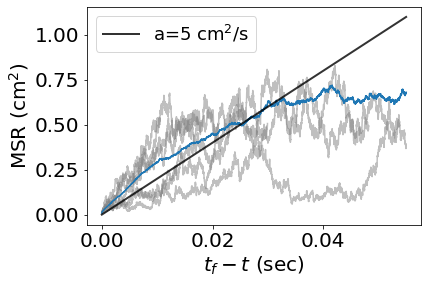

In [129]:
plt.plot(t_values,SR_values[::-1,:7],c='gray',alpha=0.5)
plt.plot(tdeath_values,MSR_values)
plt.plot(tdeath_values[1:],tdeath_values[1:]*4*a,c='k',lw=2,alpha=0.8,label=r'a=5 cm$^2$/s')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.legend(fontsize=18)
plt.show()

In [ ]:
i=6
print(range_values[::-1,i]**2)
plt.plot(t_values,range_values[::-1,i]**2,c='gray',lw=1,alpha=0.5)
plt.show()

In [ ]:
for i in range(7):#[5,7,100]:
    plt.plot(t_values,range_values[::-1,i]**2,c='gray',lw=1,alpha=0.5)
format_plot(ax=plt.gca(),xlabel='t (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

I think the problem was from when I was turning off a given particle's simulation.  If a particle stepped within the minimum distance, it had a chance to step out of that minimum distance and then be considered for another time step before being removed from the simulation.  Because of this, every particle had a nontrivial probability of "stalling" at the cutoff distance.  This "stalling" led to an attraction coefficient that was too small.  

After turning off particle motion at the end of each time step, [the simulation produced results in agreement with the case with no diffusion].

I produced a small proof supporting the independence of diffusion on the apparent attraction coefficient.  It is attached.

In [ ]:
MSR_values

In [ ]:
#make a simple plot of MSR vs tf-t
for i in [5,7,100,1000,50]:
    plt.plot(t_values,range_values[::-1,i]**2,c='gray',lw=1,alpha=0.5)
format_plot(ax=plt.gca(),xlabel='t (sec)',ylabel=r'MSR (cm$^2$)')
plt.plot(t_values[1:],MSR_values[1:]**2,c='C0',lw=2,alpha=0.5)
plt.plot(t_values[1:],t_values[1:]*4*5,c='k',lw=2,alpha=0.5,label='Expected')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.legend(fontsize=18)
plt.show()

#TODO: visualize a_SR versus tmax
#make a simple plot of MSR vs tf-t
for i in range(50):
    plt.plot(t_values,range_values[::-1,i]**2,c='gray',lw=1,alpha=0.05)
format_plot(ax=plt.gca(),xlabel='t (sec)',ylabel=r'MSR (cm$^2$)')
plt.plot(t_values[1:],MSR_values[1:]**2,c='C0',lw=2,alpha=0.5)
plt.plot(t_values[1:],t_values[1:]*4*5,c='k',lw=2,alpha=0.5,label='Expected')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.legend(fontsize=18)
plt.show()

#TODO: try to understand what the quadratic MSR versus t means

In [ ]:
#TODO: wrap map from tavg1,tavg2 to a_SR et al

In [ ]:
#TODO: dev grid search over tavg1,tavg2 to a dataframe of a_SR et al

In [ ]:
#TODO: save ^that dataframe as csv

In [ ]:
#(supposing the tavg1,tavg2 grid search is reasonably fast <1 hour),
#TODO: run a dask bag over D=0.,...,1. in min(0.1,x), where x = the minimum stepsize that should finish by the time I wakeup tomorrow
#nota bene: without too much difficulty, I could use 50 cores from ssh-miller and use ~5X smaller x...

In [ ]:
    #GOAL: vectorized processing
    # DONE: plot the basic results versus time and verify that they look reasonable
    # DONE(optional): compute the moving average of particle locations
    # DONE: compute all ranges
    # DONE: find the row index where the positions first become closer than R_thresh=0.001 cm

    #     ylabel_lst=['R (cm)','diffusive\nstep size (cm)','attractive\nstep size (cm)']
    #     fig,axs=plt.subplots(1,3,figsize=(14,4),constrained_layout=True)
    #     for i,(ax,ylabel) in enumerate(zip(axs,ylabel_lst)):
    #         ax.plot(mean_array[:,i])
    #         ax.fill_between(mean_array[:,i]-1.96*std_array[:,i],mean_array[:,i]+1.96*std_array[:,i],alpha=0.5)
    #         format_plot(ax=ax,xlabel='t (sec)',ylabel=ylabel)
    #     plt.show()


# DONE: dev alignment routine for MSR results for the full models
- DONE: bubbled relevant parameters up
- TODO: port alignment routine to care and simplify it to a function that returns msr_csv_dir

In [22]:
##########################
# Compute MSR
##########################
R_col='R_nosavgol'
# R_col='R'
#load cached data
#FK at 0.4ms
#LR at 0.5ms
# data_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_fk_tavg1_4.0_tavg2_14.00.csv'
# data_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_lr_tavg1_4.0_tavg2_14.00.csv'
data_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_fk_tavg1_0.0_tavg2_14.00.csv'
data_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_lr_tavg1_0.0_tavg2_14.00.csv'
df_fk=pd.read_csv(data_dir_fk)
df_lr=pd.read_csv(data_dir_lr)

# # print(len(save_dir_lst2))
# # print(save_dir_lst2[0])
# print(df_fk.head(2))
# print(df_lr.head(2))
#include memory preallocation 
df_fk['tdeath_align']=df_fk['tdeath'].copy()
df_lr['tdeath_align']=df_lr['tdeath'].copy()
#TODO: dev alignment routine to shift R_col and tdeath s.t. at time t=0, R=0, via linear interpolation of the at least the first two data points1

In [23]:

df=df_fk
c='C0'
tavg2=14#ms
SR_speed_align_thresh_min=0.0#cm^2/ms ~ 4*3  cm^2/s
# df=df_lr
# c='C1'
# tavg2=14#ms
# SR_speed_align_thresh_min=0.02#cm^2/ms ~ 4*3  cm^2/s


modname='msr_fk'
# modname='msr_lr'


# tmax=8#ms
tmax=1e3#ms

SR_speed_align_thresh_max=.12#cm^2/ms  ~ 4*18 cm^2/s
tshift_align_thresh_min=-2.5#ms
tshift_align_thresh_max=2.5#ms
Rfinal_thresh=0.4#cm

#to recompute savgol filtered values,
#get time step
tdeath_values_avail=df.sort_values(by='tdeath')['tdeath'].drop_duplicates().values
DT=np.around(np.median(np.diff(tdeath_values_avail)),7)

trial_col='event_id_int'
#compute savgol window
navg2=np.int64(np.around(tavg2/DT))
navg2=navg2+1 if navg2%2==0 else navg2
# navg2=5

In [24]:
savgol_kwargs=dict(
    window_length=navg2,
    polyorder=3,
    deriv=1,
    delta=1.0,
    axis=-1,
    mode='interp'
)

savgol0_kwargs=dict(
    window_length=navg2,
    polyorder=3,
    deriv=0,
    delta=1.0,
    axis=-1,
    mode='interp'
)

In [25]:
# #recompute savgol filtered values
#<30second runtime roughly
# trial_col='event_id_int'
#isolate only the columns relevant to computing the attraction coefficient, a
# df_R=df_traj[[trial_col,'pid_self','pid_other','tdeath','R_nosavgol']].dropna()
df_R=df.sort_values([trial_col,'pid_self','pid_other','tdeath'], ascending=True)#.copy()

#compute the smoothed derivative savgol_filter using scipy's cryptic cython code
grouped=df_R.groupby([trial_col,'pid_self','pid_other'])
# grouped=df_R.to_pandas().groupby([trial_col,'pid_self','pid_other'])
result = grouped['R'].apply(savgol_filter,**savgol_kwargs)
dRdt_values=np.concatenate(result.values)
df_R['dRdt']=dRdt_values/DT*1000 #cm/s

#compute the smoothed value savgol_filter using scipy's cryptic cython code
grouped=df_R.groupby([trial_col,'pid_self','pid_other'])
# grouped=df_R.to_pandas().groupby([trial_col,'pid_self','pid_other'])
result = grouped['R'].apply(savgol_filter,**savgol0_kwargs)
R_values=np.array(np.concatenate(result.values))
df_R['R']=R_values

In [26]:
#TODO: remove anything that ends more than half a centimeter away
#TODO: test/verify that the time shift is actually employed on the LR MSR timeseries

In [27]:
# # tshift_tare_routine ALREADY DONE BELOW
# #perform tshift_tare_routine for all values...
# # df_R.set_index(['event_id_int','pid_self','pid_other'])
# retval=tshift_tare_routine(df_R,navg2)#,max_num_groups=9e9,npartitions=None,R_col='R_nosavgol',printing=True,**kwargs)
df_R[['tdeath','tdeath_align']].head()

,tdeath,tdeath_align
6532408,0.0,0.0
6532407,0.4,0.4
6532406,0.8,0.8
6532405,1.2,1.2
6532404,1.6,1.6


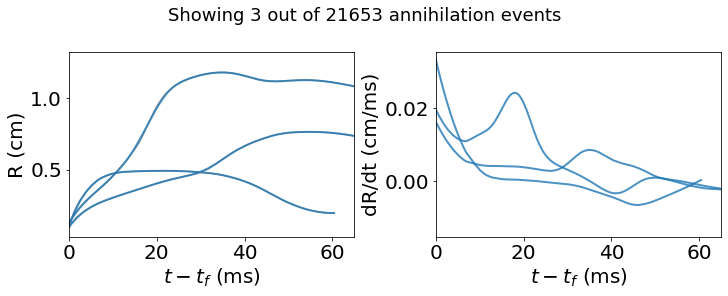

In [28]:
#compute time shifts for the first x groups
max_num_groups=3#9e9
#include memory preallocation 
plotting=True
df_R['tdeath_align']=df_R['tdeath'].copy()
#group dataframe by annihilation event
# groups=df_R.sort_values('tdeath',ascending=True).groupby(['event_id_int','pid_self','pid_other'])
groups=df_R.groupby(['event_id_int','pid_self','pid_other'])
df_Ri=df_R.set_index(['event_id_int','pid_self','pid_other'])
if plotting:
    plot_kwargs=dict(c='gray',alpha=0.8)
    fig, axs=plt.subplots(ncols=2,figsize=(10,4),constrained_layout=True)
    format_plot(ax=axs[0],xlabel=r'$t-t_f$ (ms)',ylabel='R (cm)')#,xlim=[0,65])
    format_plot(ax=axs[1],xlabel=r'$t-t_f$ (ms)',ylabel='dR/dt (cm/ms)')#,xlim=[0,65])
    axs[0].set_xlim([0,65])
    axs[1].set_xlim([0,65])
# groups=df_fk.sort_values('tdeath',ascending=True).groupby(['event_id_int','pid_self','pid_other'])
tshift_align_lst=[]
# speed_align_lst=[]
group_name_lst=[]
SR_speed_align_lst=[]
Delta_SR_speed_align_lst=[]
count=0
for group_name,g in groups:
    count+=1
    if max_num_groups>=count:
        #TODO: compute tshift_align
        # R_col='R'
        R_col='R_nosavgol'
        #TODO: extract the R_values and tdeath_values
        tdeath_values=g['tdeath'].values
        SR_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)**2
#         R_values=g['R_nosavgol'].values
        #dt=np.median(np.diff(tdeath_values))
        #perform ols least squares on the final 8 values
        y=SR_values[:8]
        x=tdeath_values[:8]
        dict_ols=compute_95CI_ols(x,y)
        
        m=dict_ols['m']
        Delta_SR_speed_align=dict_ols['Delta_m']
        
        #compute the time shift
        tf=x[0]
        tshift_align=float(tf+dict_ols['b']/m)
        
        #record
        SR_speed_align_lst.append(m)
        Delta_SR_speed_align_lst.append(Delta_SR_speed_align)
        
        #         # TODO: compute_dRdt via finite difference
        #         dSRdt_values=np.diff(SR_values)/DT*1e3
        #         # TODO: compute speed_align... is it speed_align=first deriv from savgol filtered trajectories
        #         SR_speed_align=dSRdt_values[0]
        #         #is speed_align the first finite difference of the R_values?
        #         SRfinal=SR_values[0]
        #         #the moving average of speed is computed using the savitzgy golay filtration (best linear unbiased estimator)
        #         tshift_align=float(speed_align/Rfinal/1e3)
        #compute tdeath_align from tdeath and the moving average of speed
        #tshift trajectories by that value
        g['tdeath_align']=g['tdeath_align']+tshift_align
        df_Ri.loc[group_name,'tdeath_align']=df_Ri.loc[group_name,'tdeath_align']+tshift_align
        #return this over all particles, keep track of the shift amount
        tshift_align_lst.append(tshift_align)
#         speed_align_lst.append(speed_align)
        group_name_lst.append(group_name)
        
        if plotting:
            #plot the results for this group
            ax=axs[0]
            ax.plot(tdeath_values,g['R_nosavgol'].values,label='Unfiltered',**plot_kwargs)
            ax.plot(tdeath_values,savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs),label='Sav-Gol Filtered',c=c,lw=2,alpha=0.8)
            #         ax.plot(tdeath_values,g['R'],label='Sav-Gol Filtered',c='C0',lw=2,alpha=0.8)
            ax=axs[1]
            #         ax.plot(tdeath_values,g['dRdt'].values,**plot_kwargs)
            ax.plot(tdeath_values,savgol_filter(g['R_nosavgol'].values,**savgol_kwargs),c=c,lw=2,alpha=0.8)
            #         ax.plot(tdeath_values[1:],dRdt_values,c='C0',lw=2,alpha=0.8,**plot_kwargs)

if plotting:
    fig.suptitle(f"Showing {max_num_groups} out of {count} annihilation events\n",fontsize=18)
    plt.show()

In [29]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [30]:

with HiddenPrints():
    retval=tshift_tare_routine(df_R,navg2,max_num_groups=9e9,plotting=False,npartitions=10,R_col='R_nosavgol',printing=True)
# retval=tshift_tare_routine(df_R,navg2,max_num_groups=100,plotting=False,npartitions=10,R_col='R_nosavgol',printing=True)
len(retval)

21653

In [31]:
# tshift_tare_routine
# retval


In [32]:
for rv in retval:
    if rv[:len("Warning:")+1]=="Warning:":
        print(rv)
rv

(0.9350885020532402,
 (12002003804000, 65, 54),
 0.06289373248577394,
 0.0029014870167119147)

In [33]:
#record shifts to time as field tdeath_align
for rv in retval:
    tshift_align,group_name,SR_speed_align,Delta_SR_speed_align=rv
    df_Ri.loc[group_name,'tdeath_align']=df_Ri.loc[group_name,'tdeath']+tshift_align

In [34]:
print(f"is tdeath different from tdeath_align?")
df_Ri[['tdeath','tdeath_align']].head()

is tdeath different from tdeath_align?


tdeath  tdeath_align
event_id_int  pid_self pid_other                      
1200200004000 23       17            0.0      1.204536
                       17            0.4      1.604536
                       17            0.8      2.004536
                       17            1.2      2.404536
                       17            1.6      2.804536

In [35]:
# SR_speed_align_thresh_max=.12#cm^2/ms  ~ 4*18 cm^2/s
# tshift_align_thresh_min=-2.5#ms
# tshift_align_thresh_max=2.5#ms
#filter unreasonable outliers
#perform explicit transpose via for loop
# groups=df_fk.sort_values('tdeath',ascending=True).groupby(['event_id_int','pid_self','pid_other'])
tshift_align_lst=[]
group_name_lst=[]
SR_speed_align_lst=[]
Delta_SR_speed_align_lst=[]
for rv in retval:
    tshift_align,group_name,SR_speed_align,Delta_SR_speed_align=rv
    boo=(SR_speed_align>=SR_speed_align_thresh_min) and (SR_speed_align<=SR_speed_align_thresh_max)
    boo&=(tshift_align>=tshift_align_thresh_min) and (tshift_align<=tshift_align_thresh_max)
    if boo:
        tshift_align_lst.append(tshift_align)
        group_name_lst.append(group_name)
        SR_speed_align_lst.append(SR_speed_align)
        Delta_SR_speed_align_lst.append(Delta_SR_speed_align)

dict_out={
'tshift_align':tshift_align_lst,
'group_name':group_name_lst,
'SR_speed_align':SR_speed_align_lst,
'Delta_SR_speed_align':Delta_SR_speed_align_lst
}
df_out=pd.DataFrame(dict_out)
# boo=df_out['SR_speed_align']>SR_speed_align_thresh
df_out.head()

,tshift_align,group_name,SR_speed_align,Delta_SR_speed_align
0,1.204536,"(1200200004000, 23, 17)",0.013590,0.000583
1,0.524301,"(1200200004000, 24, 12)",0.021628,0.001968
2,1.123806,"(1200200004000, 35, 18)",0.008662,0.000354
3,1.178685,"(1200200004000, 52, 66)",0.031635,0.000894
4,0.913210,"(1200200004000, 53, 50)",0.029669,0.001090


In [36]:
#         if plotting:
#             #plot the results for this group
#             ax=axs[0]
#             ax.plot(tdeath_values,g['R_nosavgol'].values,label='Unfiltered',**plot_kwargs)
#             ax.plot(tdeath_values,savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs),label='Sav-Gol Filtered',c=c,lw=2,alpha=0.8)
#             #         ax.plot(tdeath_values,g['R'],label='Sav-Gol Filtered',c='C0',lw=2,alpha=0.8)
#             ax=axs[1]
#             #         ax.plot(tdeath_values,g['dRdt'].values,**plot_kwargs)
#             ax.plot(tdeath_values,savgol_filter(g['R_nosavgol'].values,**savgol_kwargs),c=c,lw=2,alpha=0.8)
#             #         ax.plot(tdeath_values[1:],dRdt_values,c='C0',lw=2,alpha=0.8,**plot_kwargs)
    
# plotting=False 
# if plotting:
#     plot_kwargs=dict(c='gray',alpha=0.8)
#     fig, axs=plt.subplots(ncols=2,figsize=(10,4),constrained_layout=True)
#     format_plot(ax=axs[0],xlabel=r'$t-t_f$ (ms)',ylabel='R (cm)')#,xlim=[0,65])
#     format_plot(ax=axs[1],xlabel=r'$t-t_f$ (ms)',ylabel='dR/dt (cm/ms)')#,xlim=[0,65])
#     axs[0].set_xlim([0,65])
#     axs[1].set_xlim([0,65])
    
#     #TODO: plot any desired trajectories

#     fig.suptitle(f"Showing {max_num_groups} out of {count} annihilation events\n",fontsize=18)
#     plt.show()ii

In [37]:
# #GOAL: use time binned bootstrap
# #NOTE: old method of boostrapping (synchronous tdeath values) no longer is valid!  I must instead use time binned bootstrap
# # #TODO: bootstrap squared range using time bins of bin_width = np.mean(tshift_align_lst)
# bin_width=np.mean(tshift_align_lst)
# bin_width


In [38]:
# for t_align,group_name in zip(tshift_align_lst,group_name_lst):
#     pass
# df_Ri.head()

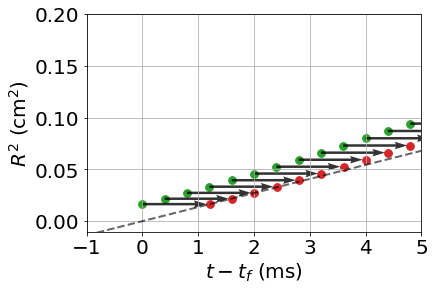

In [39]:
# for group_name in group_name_lst[:2]:
group_name=group_name_lst[0]
g=df_Ri.loc[group_name]
g.head()

x1_values=g['tdeath'].values
x2_values=g['tdeath_align'].values
y_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)**2 #cm^2


xmin,xmax=-1,5
#plot a black dotted line and show that it goes through zero
dict_ols=compute_95CI_ols(x2_values[:3],y_values[:3])
# dict_ols=compute_95CI_ols(x2_values[:8],y_values[:8])
xv=np.linspace(xmin,xmax,100)
plt.plot(xv,dict_ols['m']*xv+dict_ols['b'],'k--',alpha=0.6,lw=2)
#plot the data showing the linear transform
plt.scatter(x1_values,y_values,c='C2',s=60)
plt.scatter(x2_values,y_values,c='C3',s=60)
for x,y,u,v in zip(x1_values,y_values,x2_values-x1_values,y_values-y_values):
    plt.quiver(x,y,u,v,angles='xy', scale_units='xy', scale = 1.05, alpha=0.8,color='k')#, 0.*y_values)#, **kw)


# plt.quiver([x1_values,y_values], [x2_values,y_values],angles='xy', scale_units='xy', scale = 1)#, 0.*y_values)#, **kw)
format_plot(ax=plt.gca(),xlabel=r'$t-t_f$ (ms)',ylabel=r'$R^2$ (cm$^2$)')#,xlim=[0,65])
plt.xlim([xmin,xmax])
plt.ylim([-0.01,0.2])

# plt.quiver(0,0, 1, 1,angles='xy', scale_units='xy', scale = 1)
plt.xticks(range(-1,6))
# plt.yticks(range(-1,6))
plt.grid()
plt.draw()
plt.show()

In [40]:
# x1_values.shape,y_values.shape
np.quantile(SR_speed_align_lst,0.5)

0.028761090484079266

In [41]:
#rough estimate for a_sr
np.mean(np.array(SR_speed_align_lst)*1e3)/4,np.mean(np.array(SR_speed_align_lst))

(7.437061172584852, 0.02974824469033941)

In [42]:
# #GOAL: use time binned bootstrap
# #NOTE: old method of boostrapping (synchronous tdeath values) no longer is valid!  I must instead use time binned bootstrap
# #TODO: bootstrap squared range using time bins of bin_width = np.mean(tshift_align_lst)
# bin_width=np.mean(tshift_align_lst)
# bin_width

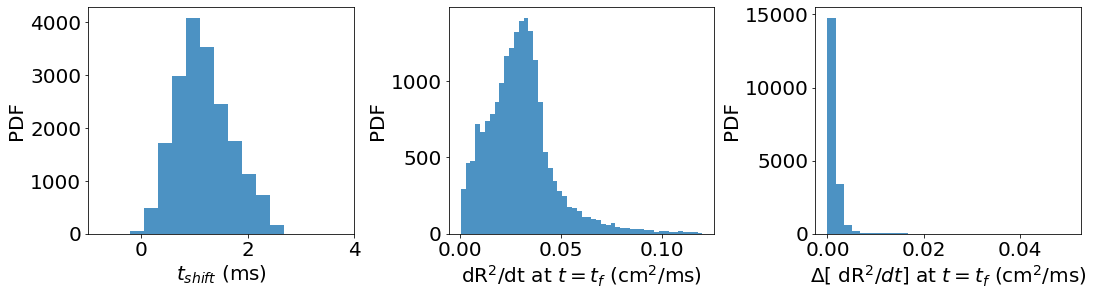

len(tshift_align_lst)=19095, len(SR_speed_align_lst)=19095, len(Delta_SR_speed_align_lst)=19095
estimate for a_sr at tf
7.437061172584852


In [43]:
# SR_speed_align_thresh=
fig,axs=plt.subplots(ncols=3,figsize=(15,4),constrained_layout=True)
axs[0].hist(tshift_align_lst,bins=np.linspace(-1,4,20),color=c,alpha=0.8)
format_plot(ax=axs[0],xlabel=r'$t_{shift}$ (ms)',ylabel='PDF')
axs[0].set_xlim([-1,4])
axs[1].hist(SR_speed_align_lst,bins=50,color=c,alpha=0.8)
format_plot(ax=axs[1],xlabel=r'dR$^2$/dt at $t=t_f$ (cm$^2$/ms)',ylabel='PDF')
axs[2].hist(Delta_SR_speed_align_lst,bins=30,color=c,alpha=0.8)
format_plot(ax=axs[2],xlabel=r'$\Delta[$ dR$^2/dt]$ at $t=t_f$ (cm$^2$/ms)',ylabel='PDF')
plt.show()
print(f"len(tshift_align_lst)={len(tshift_align_lst)}, len(SR_speed_align_lst)={len(SR_speed_align_lst)}, len(Delta_SR_speed_align_lst)={len(Delta_SR_speed_align_lst)}")
print(f"estimate for a_sr at tf")
print(np.mean(np.array(SR_speed_align_lst)*1e3)/4)

# print("""
# SR_speed_align_thresh_max=.12#cm^2/ms  ~ 4*18 cm^2/s
# SR_speed_align_thresh_min=0.02#cm^2/ms ~ 4*3  cm^2/s
# tshift_align_thresh_min=-2.5#ms
# tshift_align_thresh_max=2.5#ms
# """)

In [44]:
df_Ri[['tdeath','tdeath_align']].head()

tdeath  tdeath_align
event_id_int  pid_self pid_other                      
1200200004000 23       17            0.0      1.204536
                       17            0.4      1.604536
                       17            0.8      2.004536
                       17            1.2      2.404536
                       17            1.6      2.804536

In [45]:
df_out

,tshift_align,group_name,SR_speed_align,Delta_SR_speed_align
0,1.204536,"(1200200004000, 23, 17)",0.013590,0.000583
1,0.524301,"(1200200004000, 24, 12)",0.021628,0.001968
2,1.123806,"(1200200004000, 35, 18)",0.008662,0.000354
3,1.178685,"(1200200004000, 52, 66)",0.031635,0.000894
4,0.913210,"(1200200004000, 53, 50)",0.029669,0.001090
...,...,...,...,...
19090,2.496073,"(12002003804000, 50, 37)",0.051467,0.000289
19091,1.922485,"(12002003804000, 53, 45)",0.024976,0.000173
19092,1.565216,"(12002003804000, 61, 62)",0.038526,0.000468
19093,1.914489,"(12002003804000, 64, 58)",0.035076,0.000448


In [46]:
len(group_name_lst)

19095

In [47]:
# #visualize time shifts for the first x groups
# max_num_groups=15#9e9
# lw=2
# alpha=0.6
# #memory preallocation 
# plotting=True
# #group dataframe by annihilation event
# # groups=df_Ri.groupby(['event_id_int','pid_self','pid_other'])
# if plotting:
#     plot_kwargs=dict(c='gray',alpha=0.8)
#     fig, axs=plt.subplots(ncols=2,figsize=(10,4),constrained_layout=True)
#     format_plot(ax=axs[0],xlabel=r'$t-t_f$ (ms)',ylabel='R (cm)')#,xlim=[0,65])
#     format_plot(ax=axs[1],xlabel=r'$t-t_f$ (ms)',ylabel='dR/dt (cm/ms)')#,xlim=[0,65])
#     axs[0].set_xlim([0,65])
#     axs[1].set_xlim([0,65])

# count=0
# # for group_name,g in groups:
# for group_name in group_name_lst:
#     g=df_Ri.loc[group_name]
#     count+=1
#     if max_num_groups>=count:
#         tdeath_values=g['tdeath'].values
#         #tdeath_values=g['tdeath_align'].values
#         if plotting:
#             #plot the results for this group
#             ax=axs[0]
#             ax.plot(tdeath_values,g['R_nosavgol'].values,label='Unfiltered',**plot_kwargs)
#             ax.plot(tdeath_values,savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs),label='Sav-Gol Filtered',c=c,lw=lw,alpha=alpha)
#             #         ax.plot(tdeath_values,g['R'],label='Sav-Gol Filtered',c='C0',lw=2,alpha=0.8)
#             ax=axs[1]
#             #         ax.plot(tdeath_values,g['dRdt'].values,**plot_kwargs)
#             ax.plot(tdeath_values,savgol_filter(g['R_nosavgol'].values,**savgol_kwargs),c=c,lw=lw,alpha=alpha)
#             #         ax.plot(tdeath_values[1:],dRdt_values,c='C0',lw=2,alpha=0.8,**plot_kwargs)

# if plotting:
#     fig.suptitle(f"Showing {max_num_groups} out of {count} annihilation events\n",fontsize=18)
#     plt.show()

In [48]:
# Rfinal_thresh=0.4#cm
# tshift_align_thresh=3#ms

In [49]:
# #visualize time shifts for the first x groups
# max_num_groups=3#9e9
# lw=2
# alpha=0.6
# Rfinal_thresh=0.8#cm
# #memory preallocation 
# plotting=True
# #group dataframe by annihilation event
# # groups=df_Ri.groupby(['event_id_int','pid_self','pid_other'])
# if plotting:
#     plot_kwargs=dict(c='gray',alpha=0.8)
#     fig, axs=plt.subplots(ncols=2,figsize=(10,4),constrained_layout=True)
# #     format_plot(ax=axs[0],xlabel=r'$t-t_f$ (ms)',ylabel=r'R$^2$ (cm$^2$)')#,xlim=[0,65])
#     format_plot(ax=axs[0],xlabel=r'$t-t_f$ (ms)',ylabel='R (cm)')#,xlim=[0,65])
#     format_plot(ax=axs[1],xlabel=r'$t-t_f$ (ms)',ylabel='dR/dt (cm/ms)')#,xlim=[0,65])
#     axs[0].set_xlim([0,65])
#     axs[0].set_ylim([0,2])
#     axs[1].set_xlim([0,65])

# count=0
# # tdeath_lst=[]
# # SR_lst=[]
# # for group_name,g in groups:
# for tshift_align,group_name in zip(tshift_align_lst,group_name_lst):
#     g=df_Ri.loc[group_name]
#     count+=1
#     if max_num_groups>=count:
#         #tdeath_values=g['tdeath'].values
        
        
#         #select values that end further than Q away
#         #heretim?
#         #Rfinal=np.min(g['R_nosavgol'].values[0])
#         Rfinal=g['R_nosavgol'].values[0]
#         boo=Rfinal<=Rfinal_thresh
#         boo&=np.abs(tshift_align)<tshift_align_thresh
#         if boo:
#             tdeath_values=g['tdeath_align'].values
#             SR_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)#**2
# #             tdeath_lst.extend(tdeath_values)
# #             SR_lst.extend(SR_values)
#             if plotting:
#                 #plot the results for this group
#                 ax=axs[0]
#                 #ax.plot(tdeath_values,g['R_nosavgol'].values,label='Unfiltered',**plot_kwargs)
#                 ax.plot(tdeath_values,SR_values,label='Sav-Gol Filtered',c=c,lw=lw,alpha=alpha)
#                 #         ax.plot(tdeath_values,g['R'],label='Sav-Gol Filtered',c='C0',lw=2,alpha=0.8)
#                 ax=axs[1]
#                 #         ax.plot(tdeath_values,g['dRdt'].values,**plot_kwargs)
#                 ax.plot(tdeath_values,savgol_filter(g['R_nosavgol'].values,**savgol_kwargs),c=c,lw=lw,alpha=alpha)
#                 #         ax.plot(tdeath_values[1:],dRdt_values,c='C0',lw=2,alpha=0.8,**plot_kwargs)

# if plotting:
#     fig.suptitle(f"Showing {max_num_groups} out of {count} annihilation events\n",fontsize=18)
#     plt.show()

In [50]:
lw=2
alpha=0.09
# #visualize time shifts for the first x groups
# max_num_groups=100#9e9
# lw=2
# alpha=0.09
# Rfinal_thresh=0.8#cm
# #memory preallocation 
# plotting=True
# #group dataframe by annihilation event
# # groups=df_Ri.groupby(['event_id_int','pid_self','pid_other'])
# if plotting:
#     plot_kwargs=dict(c='gray',alpha=0.8)
#     fig, axs=plt.subplots(ncols=2,figsize=(10,4),constrained_layout=True)
#     format_plot(ax=axs[0],xlabel=r'$t-t_f$ (ms)',ylabel=r'R$^2$ (cm$^2$)')#,xlim=[0,65])
#     #format_plot(ax=axs[0],xlabel=r'$t-t_f$ (ms)',ylabel='R (cm)')#,xlim=[0,65])
#     format_plot(ax=axs[1],xlabel=r'$t-t_f$ (ms)',ylabel='dR/dt (cm/ms)')#,xlim=[0,65])
#     axs[0].set_xlim([0,65])
#     axs[0].set_ylim([0,2])
#     axs[1].set_xlim([0,65])

# count=0
# tdeath_lst=[]
# SR_lst=[]
# # for group_name,g in groups:
# for tshift_align,group_name in zip(tshift_align_lst,group_name_lst):
#     g=df_Ri.loc[group_name]
#     count+=1
#     if max_num_groups>=count:
#         #tdeath_values=g['tdeath'].values
        
        
#         #select values that end further than Q away
#         #heretim?
#         #Rfinal=np.min(g['R_nosavgol'].values[0])
#         Rfinal=g['R_nosavgol'].values[0]
#         boo=Rfinal<=Rfinal_thresh
#         boo&=np.abs(tshift_align)<tshift_align_thresh
#         if boo:
#             tdeath_values=g['tdeath_align'].values
#             SR_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)**2
#             tdeath_lst.extend(tdeath_values)
#             SR_lst.extend(SR_values)
#             if plotting:
#                 #plot the results for this group
#                 ax=axs[0]
#                 #ax.plot(tdeath_values,g['R_nosavgol'].values,label='Unfiltered',**plot_kwargs)
#                 ax.plot(tdeath_values,SR_values,label='Sav-Gol Filtered',c=c,lw=lw,alpha=alpha)
#                 #         ax.plot(tdeath_values,g['R'],label='Sav-Gol Filtered',c='C0',lw=2,alpha=0.8)
#                 ax=axs[1]
#                 #         ax.plot(tdeath_values,g['dRdt'].values,**plot_kwargs)
#                 ax.plot(tdeath_values,savgol_filter(g['R_nosavgol'].values,**savgol_kwargs),c=c,lw=lw,alpha=alpha)
#                 #         ax.plot(tdeath_values[1:],dRdt_values,c='C0',lw=2,alpha=0.8,**plot_kwargs)

# if plotting:
#     fig.suptitle(f"Showing {max_num_groups} out of {count} annihilation events\n",fontsize=18)
#     plt.show()

In [51]:
#compute bootstrap input for all data available
#visualize time shifts for the first x groups
max_num_groups=len(group_name_lst)
Rfinal_thresh=0.4#cm
tshift_align_thresh=3#ms
#memory preallocation 

count=0
count_considered=0
tdeath_lst=[]
SR_lst=[]
# for group_name,g in groups:
for tshift_align,group_name in zip(tshift_align_lst,group_name_lst):
    g=df_Ri.loc[group_name]
    count+=1
    if max_num_groups>=count:
        #tdeath_values=g['tdeath'].values
        #select values that end further than Q away
        #heretim?
        #Rfinal=np.min(g['R_nosavgol'].values[0])
        Rfinal=g['R_nosavgol'].values[0]
        boo=Rfinal<=Rfinal_thresh
        boo&=np.abs(tshift_align)<tshift_align_thresh
        if boo:
            tdeath_values=g['tdeath_align'].values
            SR_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)**2
            tdeath_lst.extend(tdeath_values)
            SR_lst.extend(SR_values)
            count_considered+=1

In [52]:
max_num_groups=count_considered
max_num_groups

19087

In [53]:
# #preallocate memory
# df_Ri['SR']=df_Ri['R_nosavgol']**2
# #TODO: bootstrap R^2, binning by tdeath_align
# for group_name,g in groups:
#     SR_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)**2
#     event_id_int,pid_self,pid_other=group_name
#     #boo=(df_Ri['event_id_int']==event_id_int)& (df_Ri['pid_self']==pid_self)& (df_Ri['pid_other']==pid_other)
#     df_Ri.loc[group_name,'SR']=SR_values
    
# x_values=df_Ri['tdeath_align'].values
# y_values=df_Ri['SR'].values


In [54]:
print(f"navg2={navg2}")

navg2=35


In [55]:
#smooth R and then return SR for a given annihilation event
def routine(data):
    navg2_local=29
    group_name,R_values=data
    #to compute tshift_align,
    #     savgol_kwargs=dict(
    #             window_length=navg2_local,
    #             polyorder=3,
    #             deriv=1,
    #             delta=1.0,
    #             axis=-1,
    #             mode='interp')
    savgol0_kwargs=dict(
            window_length=navg2_local,
            polyorder=3,
            deriv=0,
            delta=1.0,
            axis=-1,
            mode='interp')
    SR_values=savgol_filter(R_values,**savgol0_kwargs)**2
    return SR_values
    #event_id_int,pid_self,pid_other=group_name
    #boo=(df_Ri['event_id_int']==event_id_int)& (df_Ri['pid_self']==pid_self)& (df_Ri['pid_other']==pid_other)

In [1]:
# #heretim
# boo_lst=[]
# #TODO: record ^that boo filter for large R values
# boo_lst.append(boo)
# #TODO: use ^that boo filter for large R values
# # df_Ri.index.values
np.savez_compressed

<function numpy.savez_compressed(file, *args, **kwds)>

In [57]:
#not working and seems to give the wrong answer by not removing the pairs with Rfinal>Rfinal_thresh
# #parallelize with dask.bag
# task_lst=[]
# for group_name,g in groups:
#     R_values=g['R_nosavgol'].values
#     task_lst.append((group_name,R_values))
# #color squared range field in parallelizable fashion
# #DONE: dask bag accelerate tshift_tare_routine
# printing=True
# npartitions=None
# if npartitions is None:
#     npartitions=os.cpu_count()
# #all CPU version
# b = db.from_sequence(task_lst, npartitions=npartitions).map(routine)

# #DONE: evaluate task_lst
# start = time.time()
# retval = list(b)
# SR_values_lst=retval
# #preallocate memory
# df_Ri['SR']=df_Ri['R_nosavgol'].copy()**2
# #up to here took 6.05 seconds...
# assert( len(SR_values_lst)==len(groups))
# for SR_values,(group_name,g) in zip(SR_values_lst,groups):
#     df_Ri.loc[group_name,'SR']=SR_values
# if printing:
#     print(f"run time aligning trajectories was {time.time()-start:.2f} seconds.")

In [58]:
# # heretim!
# # i want bootstrap to only have boo_values, where boo if (Rfinal<Rfinal_thresh)
# #include task in bootstrap if and only if boo
# boo_lst=[]
# for group_name,g in groups:
#     tdeath_values=g['tdeath_align'].values
#     #select values that end further than Q away
#     #heretim?
#     #Rfinal=np.min(g['R_nosavgol'].values[0])
#     R_values=g['R_nosavgol'].values
#     Rfinal=R_values[0]
#     boo=Rfinal<=Rfinal_thresh
#     boo=(Rfinal<Rfinal_thresh)
#     Rfinal_values=Rfinal+0.*R_values
#     boo=(Rfinal_values<Rfinal_thresh)
#     boo_lst.extend(boo)
# #     if boo:
# #         R_values=g['R_nosavgol'].values
# #         task_lst.append((group_name,R_values))
# boo_values=np.array(boo_lst)
# print(len(boo_lst))
# boo_lst

boo

In [59]:
# # x_values=df_Ri['tdeath_align'].values
# # y_values=df_Ri['SR'].values
# x_values=np.array(tdeath_lst)
# y_values=np.array(SR_lst)
# print(x_values)
# # # # TODO: test that SR_values_lst[0] is not the same as df_Ri.loc[group_name,'R_nosavgol']
# # # SR_values_lst[-1],df_Ri.loc[group_name,'R_nosavgol'].values**2
# # boo_values=np.array(boo_lst)
# # print(len(boo_lst))

this error would occur if df_Ri is not being updated with SR_values or tdeath_align correctly...   However, the y-intercept still is not x=0...

In [60]:
# x_values.shape,y_values.shape

In [61]:
# # # #DONE: bootstrap SR, binning by tdeath_align
# # df_Ri[['tdeath','tdeath_align']].head()
# x_values_in.shape
1

1

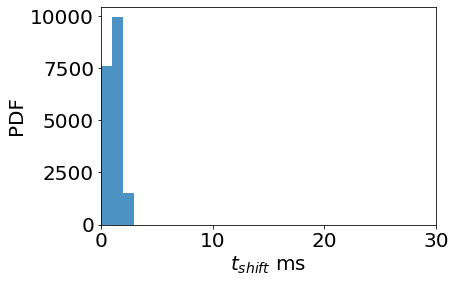

1.1788300161241767

In [62]:
plt.hist(tshift_align_lst,bins=np.arange(0,30,1),color=c,alpha=0.8)
plt.xlim(0,30)
format_plot(ax=plt.gca(),xlabel=r'$t_{shift}$ ms',ylabel=r'PDF')

plt.show()
np.mean(tshift_align_lst)

In [63]:
#compute bootstrap 
x_values_in=np.array(tdeath_lst)
y_values_in=np.array(SR_lst)
bins='auto'
# bins=np.arange(0,200,1)
# df_bootstrap=bin_and_bootstrap_xy_values_parallel(df_Ri.loc[boo_values,'tdeath_align'].values,
#                                df_Ri.loc[boo_values,'SR'].values,
df_bootstrap=bin_and_bootstrap_xy_values_parallel(x_values_in,#df_Ri.loc[boo_values,'tdeath_align'].values,
                               y_values_in,#df_Ri.loc[boo_values,'SR'].values,
                               xlabel='tdeath_avg',
                               ylabel='MSR',
                               bins=bins,
                               min_numobs=None,
                               num_bootstrap_samples=1000,
                               npartitions=10,
                               use_test=False)
# print(type(retval))
df_bootstrap.head()

,tdeath_avg,MSR,Delta_tdeath_avg,Delta_MSR,p_tdeath_avg,p_MSR,counts
0,1.313413,0.039114,0.003711,0.000254,0.091721,0.890031,44726
1,2.900176,0.090620,0.003551,0.000348,0.496601,0.953802,93990
2,4.875449,0.152585,0.003626,0.000556,0.000691,0.089183,94479
3,6.855834,0.202210,0.003740,0.000731,0.968068,0.858420,94518
4,8.836130,0.238487,0.003755,0.000848,0.939963,0.118004,94471


In [ ]:
#TODO: save df_Ri as csv if it has event_id_int still


In [64]:
#DONE: limit xlim to 180ms
#TODO: step through and find where the tshift is getting missed (i.e. fix the LR model not intersecting zero).

In [65]:
x_values=df_bootstrap['tdeath_avg'].values
y_values=df_bootstrap['MSR'].values
yerr_values=df_bootstrap['Delta_MSR'].values
x_values.shape,y_values.shape,yerr_values.shape

((495,), (495,), (495,))

In [66]:
1

1

Does this appear to intersect at zero?


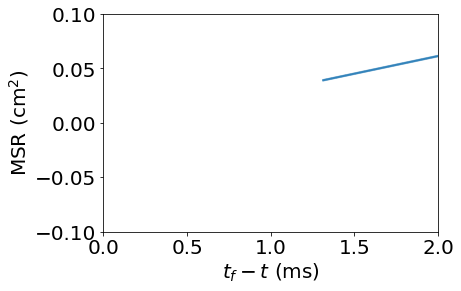

In [67]:
print(f"Does this appear to intersect at zero?")
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# plt.xlim([0,180])
# plt.ylim([0,3.1])
plt.xlim([0,2])
plt.ylim([-.1,.1])
plt.show()

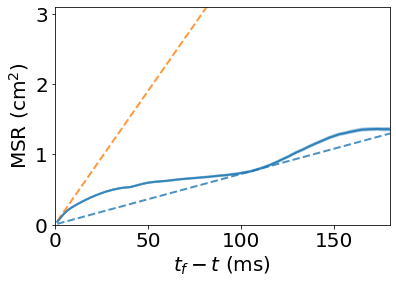

In [68]:
#plot expected
plt.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,180])
plt.ylim([0,3.1])
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

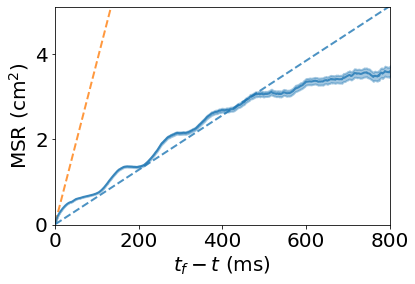

In [69]:
#plot expected
plt.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,4*1.6*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,800])
plt.ylim([0,5.1])
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

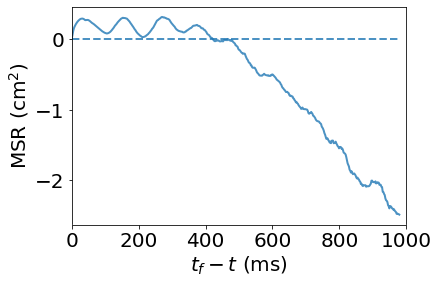

In [70]:
sig = y_values-4*1.6*1e-3*x_values
plt.plot(x_values,0*x_values,'--',lw=2,alpha=0.8,c='C0')
plt.plot(x_values,sig,lw=2,alpha=0.8,c='C0')

format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,1000])
# plt.ylim([0,5.1])
plt.show()

In [71]:
from scipy import signal
from scipy.signal import argrelextrema

In [72]:
tmax=300

In [73]:
sig = y_values-4*1.6*1e-3*x_values
boo=x_values<tmax
DT=np.diff(x_values)[0]
sig=sig[boo].copy()
corr = signal.correlate(sig, sig)
lags = signal.correlation_lags(len(sig), len(sig))
corr /= np.max(corr)

In [74]:
# for local_maxima
local_maxima=argrelextrema(corr, np.greater)

# for local_minima
local_minima=argrelextrema(corr, np.less)

#TODO: find period of MSR before death
taumax_values=DT*lags[local_maxima]
taumin_values=DT*lags[local_minima]
np.diff(taumin_values),np.diff(taumax_values)

(array([ 93.61899099, 104.7263289 ,  93.61899099]),
 array([90.44546587, 90.44546587, 90.44546587, 90.44546587]))

Periods of Autocorrelation of MSR (ms):
[90.44546587 90.44546587 90.44546587 90.44546587]


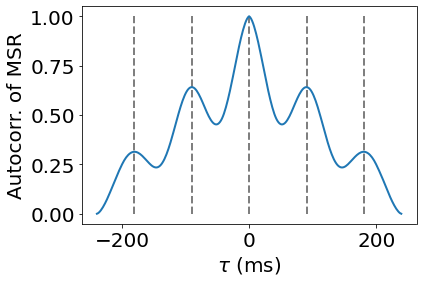

In [75]:
print(f"Periods of Autocorrelation of MSR (ms):")
print(np.diff(taumax_values))
yv=np.linspace(0,1,20)
for taumax in taumax_values:
    plt.plot(taumax+0.*yv,yv,'k--',alpha=0.5,lw=2)
    
plt.plot(DT*lags,corr,lw=2)
format_plot(ax=plt.gca(),xlabel=r'$\tau$ (ms)',ylabel=r'Autocorr. of MSR')
plt.show()

In [76]:
# # tmax=8#ms
# tmax=1e3#ms
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_SR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s")
print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

a_SR = 1.604153+/-0.040173 cm^2/s
tavg2=14 ms, num_samples=19087


In [77]:
#DONE: record ^this in .odg
#DONT: does R values have units of cm when it is saved?  maybe I'm missing a scale of 5/200???^2???
#DONE: repeat with all samples!
#TODO: repeat with more/less smoothingi
1

1

In [78]:
#save as .csv
# modname='msr_fk'
# # modname='msr_lr'
save_folder=f"{nb_dir}/data/full_results"
os.listdir(save_folder)
msr_csv_fn=f"{modname}_boostrapped_tavg2_{tavg2:.1f}_n_{max_num_groups}_a_{a_SR:.1f}_tmax_{tmax}.csv"
msr_csv_dir=os.path.join(save_folder,msr_csv_fn)
df_bootstrap.to_csv(msr_csv_dir,index=False)
msr_csv_dir

'/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'

In [79]:
beep(4)



0

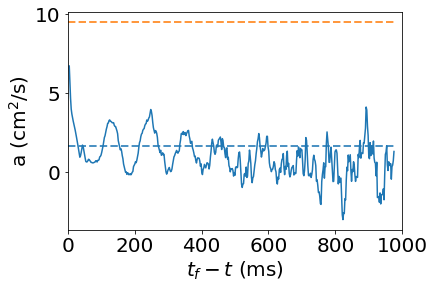

In [80]:
#plot a versus t_f-t using (i) finite diff and (ii) using savgol
xmid_values=0.5*(x_values[1:]+x_values[:-1])
dydx_values=np.diff(y_values)/np.diff(x_values)
xmid_values=moving_average(xmid_values,4)
dydx_values=moving_average(dydx_values,4)
plt.plot(xmid_values,dydx_values/4*1e3,c=c)

#plot expected
plt.plot(x_values,9.5+0.*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,1.6+0.*x_values,'--',lw=2,alpha=0.8,c='C0')

format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'a (cm$^2$/s)')
plt.xlim([0,1000])
plt.show()

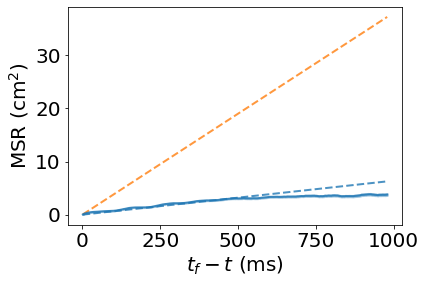

In [81]:
#plot expected
plt.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,4*1.6*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# plt.xlim([0,180])
# plt.ylim([0,3.1])
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

In [152]:
beep(3)



0

In [178]:
#TODO: repeat for FK model

## isolate the last pair from every trial

In [82]:
dfRi=df_Ri.reset_index()
tmax_series=dfRi.groupby('event_id_int')['t'].max()
event_id_values=tmax_series.index.values
tmax_values=tmax_series.values
lastgroupname_lst=[]
for tmx,event_id in zip(tmax_series,event_id_values):
    #identify the pid pair that has this tmax 
    lastgroupname=dfRi.loc[(dfRi['event_id_int']==event_id)&(dfRi['t']==tmx),['event_id_int','pid_self','pid_other']].values[0]
    lastgroupname_lst.append(tuple(lastgroupname))

In [83]:
lastgroupname_set=set(lastgroupname_lst)

In [84]:
#compute bootstrap input for all data available
#visualize time shifts for the first x groups
max_num_groups=len(group_name_lst)
Rfinal_thresh=0.4#cm
tshift_align_thresh=3#ms
#memory preallocation 

count=0
count_considered=0
tdeath_lst=[]
SR_lst=[]
# for group_name,g in groups:
for tshift_align,group_name in zip(tshift_align_lst,group_name_lst):
    g=df_Ri.loc[group_name]
    count+=1
    if max_num_groups>=count:
        #tdeath_values=g['tdeath'].values
        #select values that end further than Q away
        #heretim?
        #Rfinal=np.min(g['R_nosavgol'].values[0])
        Rfinal=g['R_nosavgol'].values[0]
        boo=Rfinal<=Rfinal_thresh
        boo&=np.abs(tshift_align)<tshift_align_thresh
        #include only if this is the last group for the trial
        boo&=lastgroupname_set.issuperset({group_name})
        if boo:
            tdeath_values=g['tdeath_align'].values
            SR_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)**2
            tdeath_lst.extend(tdeath_values)
            SR_lst.extend(SR_values)
            count_considered+=1

In [85]:
max_num_groups=count_considered
#compute bootstrap 
x_values_in=np.array(tdeath_lst)
y_values_in=np.array(SR_lst)
bins='auto'
# bins=np.arange(0,200,1)
# df_bootstrap=bin_and_bootstrap_xy_values_parallel(df_Ri.loc[boo_values,'tdeath_align'].values,
#                                df_Ri.loc[boo_values,'SR'].values,
df_bootstrap=bin_and_bootstrap_xy_values_parallel(x_values_in,#df_Ri.loc[boo_values,'tdeath_align'].values,
                               y_values_in,#df_Ri.loc[boo_values,'SR'].values,
                               xlabel='tdeath_avg',
                               ylabel='MSR',
                               bins=bins,
                               min_numobs=None,
                               num_bootstrap_samples=1000,
                               npartitions=10,
                               use_test=False)
# print(type(retval))
df_bootstrap.head()

,tdeath_avg,MSR,Delta_tdeath_avg,Delta_MSR,p_tdeath_avg,p_MSR,counts
0,3.818706,0.122991,0.050741,0.002969,0.571493,0.167170,4134
1,10.017388,0.268808,0.052862,0.004900,0.277153,0.521908,4823
2,16.660685,0.375404,0.053070,0.006860,0.367814,0.804189,4810
3,23.315171,0.463709,0.054537,0.009375,0.527660,0.148464,4839
4,29.971880,0.528188,0.054234,0.011963,0.929570,0.030868,4813


In [86]:
x_values=df_bootstrap['tdeath_avg'].values
y_values=df_bootstrap['MSR'].values
yerr_values=df_bootstrap['Delta_MSR'].values
x_values.shape,y_values.shape,yerr_values.shape

((96,), (96,), (96,))

In [98]:
tmax=24#ms
# tmax=1e3#ms
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_SR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s")
print(f"tavg2={tavg2} ms, num_samples={max_num_groups},tmax={tmax}")

a_SR = 4.323003+/-0.792421 cm^2/s
tavg2=14 ms, num_samples=290,tmax=24


In [88]:
#save as .csv
# modname='msr_fk'
# # modname='msr_lr'
save_folder=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results"
os.listdir(save_folder)
msr_csv_fn=f"{modname}_boostrapped_tavg2_{tavg2:.1f}_n_{max_num_groups}_a_{a_SR:.1f}_tmax_{tmax}_final_only.csv"
msr_csv_dir=os.path.join(save_folder,msr_csv_fn)
df_bootstrap.to_csv(msr_csv_dir,index=False)
msr_csv_dir

'/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_290_a_1.9_tmax_300_final_only.csv'

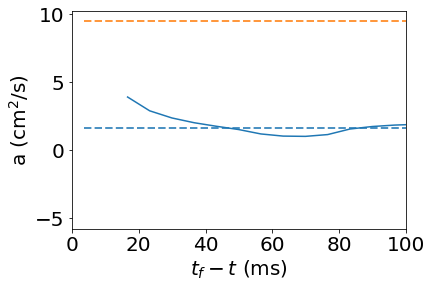

In [93]:
#plot a versus t_f-t using (i) finite diff and (ii) using savgol
xmid_values=0.5*(x_values[1:]+x_values[:-1])
dydx_values=np.diff(y_values)/np.diff(x_values)
xmid_values=moving_average(xmid_values,4)
dydx_values=moving_average(dydx_values,4)
plt.plot(xmid_values,dydx_values/4*1e3,c=c)

#plot expected
plt.plot(x_values,9.5+0.*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,1.6+0.*x_values,'--',lw=2,alpha=0.8,c='C0')

format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'a (cm$^2$/s)')
plt.xlim([0,100])
plt.show()

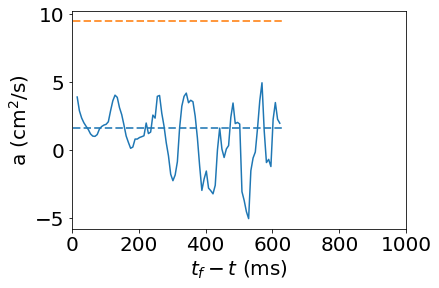

In [94]:
#plot a versus t_f-t using (i) finite diff and (ii) using savgol
xmid_values=0.5*(x_values[1:]+x_values[:-1])
dydx_values=np.diff(y_values)/np.diff(x_values)
xmid_values=moving_average(xmid_values,4)
dydx_values=moving_average(dydx_values,4)
plt.plot(xmid_values,dydx_values/4*1e3,c=c)

#plot expected
plt.plot(x_values,9.5+0.*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,1.6+0.*x_values,'--',lw=2,alpha=0.8,c='C0')

format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'a (cm$^2$/s)')
plt.xlim([0,1000])
plt.show()

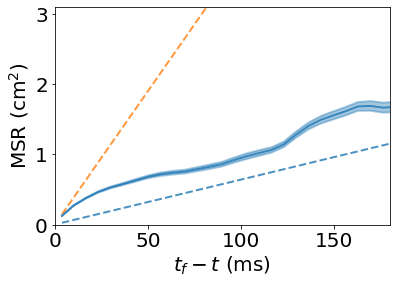

In [90]:
#plot expected
plt.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,4*1.6*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,180])
plt.ylim([0,3.1])
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

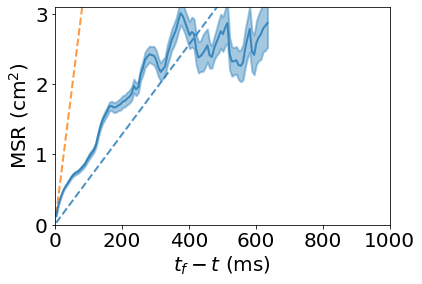

In [95]:
#plot expected
plt.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,4*1.6*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,1000])
plt.ylim([0,3.1])
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

# plot msr estimated from the full models

In [169]:
#TODO: estimate a_sr expected for this value with a sliding window
msr_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
a_LR = 8.5950#+/-0.3771 cm^2/s
# tavg2=14 ms, num_samples=2083

msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
a_FK = 1.604153#+/-0.040173 cm^2/s
# tavg2=14 ms, num_samples=19087, tmin=0, tmax=300 ms

In [179]:
df_msd_lr=pd.read_csv(msr_dir_lr)
x_values_LR=df_msd_lr['tdeath_avg'].values
y_values_LR=df_msd_lr['MSR'].values
yerr_values_LR=df_msd_lr['Delta_MSR'].values
df_msd_fk=pd.read_csv(msr_dir_fk)
x_values_FK=df_msd_fk['tdeath_avg'].values
y_values_FK=df_msd_fk['MSR'].values
yerr_values_FK=df_msd_fk['Delta_MSR'].values

In [196]:
tmax=80#ms
x_values=x_values_FK.copy()
y_values=y_values_FK.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_FK = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_FK=a_SR

tmax=60#ms
x_values=x_values_LR.copy()
y_values=y_values_LR.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_LR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_LR=a_SR

a_hat_FK = 1.509282+/-0.178827 cm^2/s, tmax=90
a_hat_LR = 3.535902+/-0.312245 cm^2/s, tmax=60


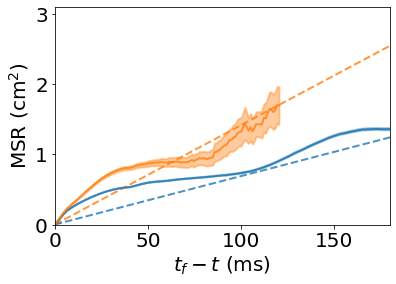

In [195]:
#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,180])
plt.ylim([0,3.1])
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

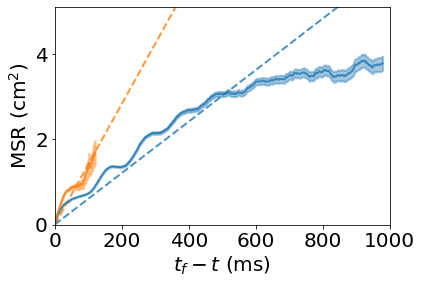

In [198]:
#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,1000])
plt.ylim([0,5.1])
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

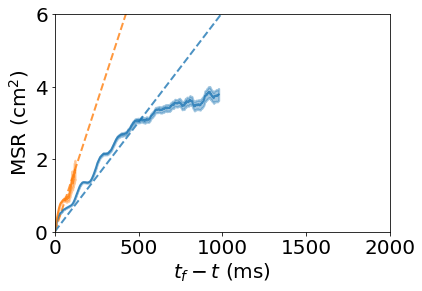

In [201]:
#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,2000])
plt.ylim([0,6])
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")